### LSTM on Amazon fine food reviews data

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout

#Importing Cleaned & Deduped dataset
# using the SQLite Table to read data.
con = sqlite3.connect('C:/Users/deepak/Documents/Applied AI assignments/3. Tsne on Amazon fine food/final.sqlite') 

In [5]:
Data = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 

In [6]:
Data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [7]:
Data.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [8]:
#Sorting the data ascending order
Data=Data.sort_values("Time",ascending = True)

text = Data['CleanedText'].values
y = Data['Score']

In [9]:
# Finding all words in the vocabulary
count_vect = CountVectorizer() 
count_vect.fit(text)

vocabulary = count_vect.get_feature_names()
print(len(vocabulary))

71624


In [10]:
# Code reference - https://stackoverflow.com/questions/4088265/sorted-word-frequency-count-using-python
from collections import Counter
cnt = Counter()
for sent in text:
  for word in sent.split():
    cnt[word] += 1

In [11]:
cnt

Counter({'witti': 11,
         'littl': 51736,
         'book': 2053,
         'make': 84947,
         'son': 7969,
         'laugh': 534,
         'loud': 318,
         'recit': 13,
         'car': 1961,
         'drive': 1699,
         'along': 5326,
         'alway': 23391,
         'sing': 226,
         'refrain': 49,
         'hes': 2956,
         'learn': 3231,
         'whale': 25,
         'india': 874,
         'droop': 18,
         'love': 115870,
         'new': 16363,
         'word': 3310,
         'introduc': 2137,
         'silli': 410,
         'classic': 1700,
         'will': 1227,
         'bet': 834,
         'still': 26898,
         'abl': 11326,
         'memori': 1338,
         'colleg': 1014,
         'rememb': 5390,
         'see': 19430,
         'show': 4202,
         'air': 2281,
         'televis': 78,
         'year': 38581,
         'ago': 9559,
         'child': 2414,
         'sister': 1781,
         'later': 5061,
         'bought': 32167,
         'da

In [12]:
#Sorting cnt in descending order
import operator
sort_cnt = sorted(cnt.items(), key=operator.itemgetter(1), reverse=True)[:5000]

In [13]:
sort_cnt

[('like', 171759),
 ('tast', 163632),
 ('flavor', 129199),
 ('good', 127807),
 ('product', 119251),
 ('use', 119190),
 ('one', 117295),
 ('love', 115870),
 ('great', 109772),
 ('tri', 104544),
 ('tea', 95553),
 ('coffe', 93530),
 ('get', 85911),
 ('make', 84947),
 ('food', 77556),
 ('would', 73540),
 ('buy', 67950),
 ('time', 65063),
 ('realli', 62110),
 ('eat', 61519),
 ('amazon', 59754),
 ('order', 59313),
 ('dont', 58266),
 ('much', 57173),
 ('price', 55750),
 ('also', 54934),
 ('find', 53463),
 ('littl', 51736),
 ('bag', 50491),
 ('best', 50454),
 ('dog', 49943),
 ('even', 49851),
 ('drink', 49442),
 ('well', 49391),
 ('store', 47080),
 ('ive', 46705),
 ('better', 43472),
 ('chocol', 42800),
 ('box', 42742),
 ('mix', 42030),
 ('day', 40876),
 ('water', 39567),
 ('sugar', 38945),
 ('year', 38581),
 ('recommend', 38565),
 ('look', 38470),
 ('sweet', 38055),
 ('first', 37859),
 ('want', 36992),
 ('packag', 36257),
 ('cup', 35955),
 ('give', 35879),
 ('brand', 35768),
 ('found', 35429)

In [14]:
len(sort_cnt)

5000

In [15]:
# Assigning Index to top most sorted words 
word_index_lookup = dict()
i = 1
# https://stackoverflow.com/questions/5466618/too-many-values-to-unpack-iterating-over-a-dict-key-string-value-list
for word,frequency in sort_cnt:
    word_index_lookup[word] = i
    i += 1

In [16]:
word_index_lookup

{'like': 1,
 'tast': 2,
 'flavor': 3,
 'good': 4,
 'product': 5,
 'use': 6,
 'one': 7,
 'love': 8,
 'great': 9,
 'tri': 10,
 'tea': 11,
 'coffe': 12,
 'get': 13,
 'make': 14,
 'food': 15,
 'would': 16,
 'buy': 17,
 'time': 18,
 'realli': 19,
 'eat': 20,
 'amazon': 21,
 'order': 22,
 'dont': 23,
 'much': 24,
 'price': 25,
 'also': 26,
 'find': 27,
 'littl': 28,
 'bag': 29,
 'best': 30,
 'dog': 31,
 'even': 32,
 'drink': 33,
 'well': 34,
 'store': 35,
 'ive': 36,
 'better': 37,
 'chocol': 38,
 'box': 39,
 'mix': 40,
 'day': 41,
 'water': 42,
 'sugar': 43,
 'year': 44,
 'recommend': 45,
 'look': 46,
 'sweet': 47,
 'first': 48,
 'want': 49,
 'packag': 50,
 'cup': 51,
 'give': 52,
 'brand': 53,
 'found': 54,
 'purchas': 55,
 'high': 56,
 'think': 57,
 'treat': 58,
 'made': 59,
 'work': 60,
 'way': 61,
 'bought': 62,
 'enjoy': 63,
 'say': 64,
 'need': 65,
 'know': 66,
 'delici': 67,
 'thing': 68,
 'nice': 69,
 'differ': 70,
 'two': 71,
 'review': 72,
 'sinc': 73,
 'add': 74,
 'pack': 75,
 'b

In [17]:
#Adding index column to the text
def apply_text_index(row):  
    holder = []
    for word in row['CleanedText'].split():
        if word in word_index_lookup:
            holder.append(word_index_lookup[word]) 
        else:
            holder.append(0)            
    return holder  

In [18]:
Data['CleanedText_Index'] = Data.apply(lambda row: apply_text_index(row),axis=1)

In [19]:
Data['Score'] = Data['Score'].map(lambda x : 1 if x == 'positive' else 0)

In [20]:
Data

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_Index
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,"[0, 28, 1082, 14, 369, 2405, 3182, 0, 1117, 12..."
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,"[540, 135, 660, 1009, 0, 44, 309, 976, 1186, 5..."
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,"[4412, 34, 1981, 1215, 343, 167, 1778, 455, 48..."
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,"[1576, 0, 3798, 2581, 204, 2520, 0, 0, 0, 943,..."
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,"[4412, 167, 1423, 1215, 0, 0, 0, 4412, 9, 455,..."
245,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...,"[7, 1215, 1215, 1682, 273, 0, 3070, 759, 348, ..."
308,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...,"[103, 63, 1215, 1423, 2210, 116, 1086, 456, 0,..."
215,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...,"[62, 1034, 4071, 173, 1546, 368, 852, 83, 1546..."
261,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...,"[629, 64, 533, 280, 18, 2520, 0, 204, 0, 71, 3..."
325,346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,get crazi look beatlejuic french version video...,"[13, 823, 46, 0, 492, 378, 2339, 19, 1277, 620..."


In [21]:
# 70-30 split
x = Data['CleanedText_Index'].values
y = Data['Score']

from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [22]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_train.shape)

(254919,)
(109252,)
(254919,)
(254919,)


In [23]:
x_train

array([list([8, 4313, 12, 0, 229, 98, 112, 229, 12, 718, 203]),
       list([62, 48, 18, 21, 195, 211, 50, 9, 204, 98, 3228, 46, 1211, 159, 55, 105, 211, 1012, 50, 688, 189, 50, 76, 286, 2610, 110, 149, 240, 749, 46, 1, 3177, 295, 3228, 143, 240, 0, 1009, 1, 3499, 180, 1561, 311, 19, 1, 1012, 211, 75]),
       list([205, 7, 118, 716, 1203, 1181, 3164, 512, 387, 613, 257, 743, 468, 200, 402, 1203]),
       ...,
       list([471, 14, 1489, 215, 177, 2, 19, 4, 373, 40, 106, 406, 782, 2375, 373, 52, 471, 1489, 1116, 325, 642, 3, 494, 1, 165, 925, 1307, 296, 215, 745, 2, 1, 200, 53, 500, 313, 643, 272, 375, 1367, 146, 254, 108, 37, 1965, 4195]),
       list([1817, 834, 222, 0, 43, 182, 18, 375, 167, 112, 9, 17, 85, 1701, 120]),
       list([1, 72, 54, 4153, 1010, 109, 643, 8, 22, 397, 9, 83, 68, 90, 255, 10, 995, 2125, 549, 672, 427, 706, 1720, 9, 170, 460, 32, 9, 706, 1748, 68, 1, 68, 1, 702, 500, 479, 4, 16, 670, 340, 14, 22, 623, 118, 18])],
      dtype=object)

In [24]:
# max words in single sentence of cleaned text to apply padding
Data['number_of_words'] = Data.CleanedText.apply(lambda x: len(x.split()))
sort_data=Data.sort_values(by='number_of_words', axis=0, ascending=False)

In [25]:
sort_data.head(1)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_Index,number_of_words
330463,63237,68701,B0051BWU92,A2GZG363BPADYC,Larry Deemer,4,4,1,1323993600,SEARCHING FOR A PET APPETITE ENHANCER?,**********************************************...,read updat first thank june august activ anywa...,"[232, 1247, 48, 172, 2673, 2992, 1190, 574, 50...",1355


In [26]:
max_review_length = 1355 # set as per the max no of words in single sentence
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print("Total number words present in first review after padding:\n",len(x_train[0]))
print()
print("List of word indexes present in first review padding:\n", x_train[0])
print()

Total number words present in first review after padding:
 1355

List of word indexes present in first review padding:
 [  0   0   0 ...  12 718 203]



In [40]:
#function for plotting train v/s validation loss
def plt_dynamic(x, vy, ty):
  plt.figure(figsize=(10,5))
  plt.plot(x, vy, 'b', label="Validation Loss")
  plt.plot(x, ty, 'r', label="Train Loss")
  plt.xlabel('Epochs') 
  plt.ylabel('Binary Crossentropy Loss')
  plt.title('\nBinary Crossentropy Loss VS Epochs')
  plt.legend()
  plt.grid()
  plt.show()

In [1]:
from __future__ import print_function
import numpy

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import numpy

from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from sklearn.model_selection import RandomizedSearchCV

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Using TensorFlow backend.


#### Trying different LSTM Layers

##### 1. 1 LSTM LAYER

In [37]:
# create the model
embedding_vecor_length = 32
model_1 = Sequential()
model_1.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))
model_1.add(Dropout(0.5))
model_1.add(CuDNNLSTM(256))
model_1.add(Dropout(0.3))
model_1.add(Dense(1, activation='sigmoid'))
print(model_1.summary())

# Compiling the model
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1355, 32)          2291968   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1355, 32)          0         
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 256)               296960    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 2,589,185
Trainable params: 2,589,185
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
# Fitting the data to the model
history = model_1.fit(x_train, y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(x_test, y_test))

C:\Users\deepak\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 254919 samples, validate on 109252 samples
Epoch 1/10
103936/254919 [===========>..................] - ETA: 11:24 - loss: 0.6935 - acc: 0.45 - ETA: 8:06 - loss: 0.6857 - acc: 0.6455 - ETA: 6:56 - loss: 0.6759 - acc: 0.714 - ETA: 6:22 - loss: 0.6628 - acc: 0.743 - ETA: 6:03 - loss: 0.6399 - acc: 0.760 - ETA: 5:49 - loss: 0.6182 - acc: 0.771 - ETA: 5:39 - loss: 0.5921 - acc: 0.783 - ETA: 5:31 - loss: 0.5734 - acc: 0.792 - ETA: 5:24 - loss: 0.5576 - acc: 0.798 - ETA: 5:21 - loss: 0.5487 - acc: 0.801 - ETA: 5:17 - loss: 0.5365 - acc: 0.806 - ETA: 5:13 - loss: 0.5306 - acc: 0.808 - ETA: 5:09 - loss: 0.5198 - acc: 0.812 - ETA: 5:07 - loss: 0.5109 - acc: 0.816 - ETA: 5:04 - loss: 0.5063 - acc: 0.818 - ETA: 5:02 - loss: 0.5031 - acc: 0.818 - ETA: 5:00 - loss: 0.4970 - acc: 0.821 - ETA: 4:58 - loss: 0.4917 - acc: 0.823 - ETA: 4:56 - loss: 0.4902 - acc: 0.823 - ETA: 4:54 - loss: 0.4887 - acc: 0.823 - ETA: 4:53 - loss: 0.4869 - acc: 0.823 - ETA: 4:51 - loss: 0.4830 - acc: 0.825 - ETA: 4:

104448/254919 [===========>..................] - ETA: 4:42 - loss: 0.2068 - acc: 0.931 - ETA: 4:42 - loss: 0.2038 - acc: 0.925 - ETA: 4:41 - loss: 0.1945 - acc: 0.926 - ETA: 4:42 - loss: 0.2016 - acc: 0.922 - ETA: 4:43 - loss: 0.1950 - acc: 0.925 - ETA: 4:43 - loss: 0.1880 - acc: 0.929 - ETA: 4:43 - loss: 0.1856 - acc: 0.930 - ETA: 4:42 - loss: 0.1876 - acc: 0.929 - ETA: 4:42 - loss: 0.1873 - acc: 0.928 - ETA: 4:40 - loss: 0.1838 - acc: 0.929 - ETA: 4:40 - loss: 0.1841 - acc: 0.929 - ETA: 4:39 - loss: 0.1852 - acc: 0.928 - ETA: 4:39 - loss: 0.1867 - acc: 0.928 - ETA: 4:38 - loss: 0.1888 - acc: 0.926 - ETA: 4:38 - loss: 0.1884 - acc: 0.927 - ETA: 4:37 - loss: 0.1903 - acc: 0.926 - ETA: 4:37 - loss: 0.1889 - acc: 0.927 - ETA: 4:36 - loss: 0.1864 - acc: 0.928 - ETA: 4:35 - loss: 0.1879 - acc: 0.927 - ETA: 4:35 - loss: 0.1875 - acc: 0.927 - ETA: 4:34 - loss: 0.1864 - acc: 0.928 - ETA: 4:33 - loss: 0.1889 - acc: 0.927 - ETA: 4:33 - loss: 0.1888 - acc: 0.927 - ETA: 4:32 - loss: 0.1885 - acc:

254919/254919 [==============================] - ETA: 51s - loss: 0.1953 - acc: 0.92 - ETA: 50s - loss: 0.1953 - acc: 0.92 - ETA: 49s - loss: 0.1953 - acc: 0.92 - ETA: 49s - loss: 0.1952 - acc: 0.92 - ETA: 48s - loss: 0.1952 - acc: 0.92 - ETA: 48s - loss: 0.1952 - acc: 0.92 - ETA: 47s - loss: 0.1951 - acc: 0.92 - ETA: 46s - loss: 0.1951 - acc: 0.92 - ETA: 46s - loss: 0.1951 - acc: 0.92 - ETA: 45s - loss: 0.1951 - acc: 0.92 - ETA: 45s - loss: 0.1950 - acc: 0.92 - ETA: 44s - loss: 0.1950 - acc: 0.92 - ETA: 44s - loss: 0.1950 - acc: 0.92 - ETA: 43s - loss: 0.1948 - acc: 0.92 - ETA: 42s - loss: 0.1949 - acc: 0.92 - ETA: 42s - loss: 0.1949 - acc: 0.92 - ETA: 41s - loss: 0.1949 - acc: 0.92 - ETA: 41s - loss: 0.1949 - acc: 0.92 - ETA: 40s - loss: 0.1949 - acc: 0.92 - ETA: 39s - loss: 0.1950 - acc: 0.92 - ETA: 39s - loss: 0.1949 - acc: 0.92 - ETA: 38s - loss: 0.1949 - acc: 0.92 - ETA: 38s - loss: 0.1948 - acc: 0.92 - ETA: 37s - loss: 0.1949 - acc: 0.92 - ETA: 37s - loss: 0.1950 - acc: 0.92 - E

104448/254919 [===========>..................] - ETA: 4:45 - loss: 0.1999 - acc: 0.935 - ETA: 4:39 - loss: 0.1894 - acc: 0.930 - ETA: 4:42 - loss: 0.1875 - acc: 0.931 - ETA: 4:41 - loss: 0.1841 - acc: 0.931 - ETA: 4:42 - loss: 0.1883 - acc: 0.928 - ETA: 4:42 - loss: 0.1811 - acc: 0.932 - ETA: 4:42 - loss: 0.1823 - acc: 0.932 - ETA: 4:41 - loss: 0.1833 - acc: 0.930 - ETA: 4:41 - loss: 0.1890 - acc: 0.928 - ETA: 4:40 - loss: 0.1882 - acc: 0.928 - ETA: 4:40 - loss: 0.1885 - acc: 0.929 - ETA: 4:40 - loss: 0.1889 - acc: 0.928 - ETA: 4:39 - loss: 0.1908 - acc: 0.927 - ETA: 4:39 - loss: 0.1897 - acc: 0.926 - ETA: 4:38 - loss: 0.1903 - acc: 0.926 - ETA: 4:38 - loss: 0.1876 - acc: 0.927 - ETA: 4:37 - loss: 0.1863 - acc: 0.927 - ETA: 4:36 - loss: 0.1868 - acc: 0.927 - ETA: 4:36 - loss: 0.1859 - acc: 0.927 - ETA: 4:36 - loss: 0.1858 - acc: 0.928 - ETA: 4:35 - loss: 0.1847 - acc: 0.928 - ETA: 4:35 - loss: 0.1831 - acc: 0.928 - ETA: 4:34 - loss: 0.1832 - acc: 0.928 - ETA: 4:33 - loss: 0.1826 - acc:

254919/254919 [==============================] - ETA: 50s - loss: 0.1832 - acc: 0.92 - ETA: 50s - loss: 0.1832 - acc: 0.92 - ETA: 49s - loss: 0.1833 - acc: 0.92 - ETA: 49s - loss: 0.1833 - acc: 0.92 - ETA: 48s - loss: 0.1832 - acc: 0.92 - ETA: 48s - loss: 0.1832 - acc: 0.92 - ETA: 47s - loss: 0.1833 - acc: 0.92 - ETA: 46s - loss: 0.1833 - acc: 0.92 - ETA: 46s - loss: 0.1832 - acc: 0.92 - ETA: 45s - loss: 0.1832 - acc: 0.92 - ETA: 45s - loss: 0.1832 - acc: 0.92 - ETA: 44s - loss: 0.1832 - acc: 0.92 - ETA: 44s - loss: 0.1832 - acc: 0.92 - ETA: 43s - loss: 0.1832 - acc: 0.92 - ETA: 42s - loss: 0.1832 - acc: 0.92 - ETA: 42s - loss: 0.1832 - acc: 0.92 - ETA: 41s - loss: 0.1832 - acc: 0.92 - ETA: 41s - loss: 0.1831 - acc: 0.92 - ETA: 40s - loss: 0.1832 - acc: 0.92 - ETA: 39s - loss: 0.1832 - acc: 0.92 - ETA: 39s - loss: 0.1832 - acc: 0.92 - ETA: 38s - loss: 0.1832 - acc: 0.92 - ETA: 38s - loss: 0.1832 - acc: 0.92 - ETA: 37s - loss: 0.1832 - acc: 0.92 - ETA: 37s - loss: 0.1831 - acc: 0.92 - E

104448/254919 [===========>..................] - ETA: 4:45 - loss: 0.1629 - acc: 0.939 - ETA: 4:47 - loss: 0.1859 - acc: 0.928 - ETA: 4:44 - loss: 0.1851 - acc: 0.926 - ETA: 4:45 - loss: 0.1805 - acc: 0.932 - ETA: 4:45 - loss: 0.1741 - acc: 0.933 - ETA: 4:45 - loss: 0.1771 - acc: 0.932 - ETA: 4:44 - loss: 0.1759 - acc: 0.931 - ETA: 4:43 - loss: 0.1760 - acc: 0.930 - ETA: 4:42 - loss: 0.1772 - acc: 0.929 - ETA: 4:42 - loss: 0.1726 - acc: 0.930 - ETA: 4:41 - loss: 0.1752 - acc: 0.928 - ETA: 4:41 - loss: 0.1738 - acc: 0.929 - ETA: 4:40 - loss: 0.1743 - acc: 0.930 - ETA: 4:39 - loss: 0.1726 - acc: 0.930 - ETA: 4:39 - loss: 0.1721 - acc: 0.930 - ETA: 4:38 - loss: 0.1734 - acc: 0.930 - ETA: 4:38 - loss: 0.1734 - acc: 0.930 - ETA: 4:37 - loss: 0.1727 - acc: 0.930 - ETA: 4:36 - loss: 0.1741 - acc: 0.930 - ETA: 4:36 - loss: 0.1729 - acc: 0.930 - ETA: 4:35 - loss: 0.1727 - acc: 0.931 - ETA: 4:35 - loss: 0.1731 - acc: 0.931 - ETA: 4:34 - loss: 0.1737 - acc: 0.930 - ETA: 4:33 - loss: 0.1732 - acc:

254919/254919 [==============================] - ETA: 51s - loss: 0.1728 - acc: 0.93 - ETA: 50s - loss: 0.1727 - acc: 0.93 - ETA: 49s - loss: 0.1728 - acc: 0.93 - ETA: 49s - loss: 0.1727 - acc: 0.93 - ETA: 48s - loss: 0.1728 - acc: 0.93 - ETA: 48s - loss: 0.1728 - acc: 0.93 - ETA: 47s - loss: 0.1729 - acc: 0.93 - ETA: 47s - loss: 0.1729 - acc: 0.93 - ETA: 46s - loss: 0.1729 - acc: 0.93 - ETA: 45s - loss: 0.1729 - acc: 0.93 - ETA: 45s - loss: 0.1729 - acc: 0.93 - ETA: 44s - loss: 0.1730 - acc: 0.93 - ETA: 44s - loss: 0.1731 - acc: 0.93 - ETA: 43s - loss: 0.1732 - acc: 0.93 - ETA: 42s - loss: 0.1731 - acc: 0.93 - ETA: 42s - loss: 0.1731 - acc: 0.93 - ETA: 41s - loss: 0.1730 - acc: 0.93 - ETA: 41s - loss: 0.1730 - acc: 0.93 - ETA: 40s - loss: 0.1730 - acc: 0.93 - ETA: 40s - loss: 0.1730 - acc: 0.93 - ETA: 39s - loss: 0.1730 - acc: 0.93 - ETA: 38s - loss: 0.1730 - acc: 0.93 - ETA: 38s - loss: 0.1730 - acc: 0.93 - ETA: 37s - loss: 0.1730 - acc: 0.93 - ETA: 37s - loss: 0.1731 - acc: 0.93 - E

104448/254919 [===========>..................] - ETA: 4:47 - loss: 0.1295 - acc: 0.941 - ETA: 4:46 - loss: 0.1605 - acc: 0.933 - ETA: 4:46 - loss: 0.1642 - acc: 0.932 - ETA: 4:43 - loss: 0.1633 - acc: 0.931 - ETA: 4:44 - loss: 0.1674 - acc: 0.927 - ETA: 4:44 - loss: 0.1710 - acc: 0.923 - ETA: 4:43 - loss: 0.1783 - acc: 0.922 - ETA: 4:43 - loss: 0.1787 - acc: 0.922 - ETA: 4:41 - loss: 0.1745 - acc: 0.924 - ETA: 4:41 - loss: 0.1728 - acc: 0.925 - ETA: 4:41 - loss: 0.1722 - acc: 0.925 - ETA: 4:40 - loss: 0.1714 - acc: 0.925 - ETA: 4:40 - loss: 0.1704 - acc: 0.926 - ETA: 4:39 - loss: 0.1720 - acc: 0.926 - ETA: 4:39 - loss: 0.1715 - acc: 0.926 - ETA: 4:38 - loss: 0.1705 - acc: 0.927 - ETA: 4:37 - loss: 0.1716 - acc: 0.927 - ETA: 4:37 - loss: 0.1712 - acc: 0.927 - ETA: 4:36 - loss: 0.1698 - acc: 0.928 - ETA: 4:36 - loss: 0.1692 - acc: 0.928 - ETA: 4:35 - loss: 0.1680 - acc: 0.929 - ETA: 4:34 - loss: 0.1668 - acc: 0.929 - ETA: 4:34 - loss: 0.1657 - acc: 0.930 - ETA: 4:33 - loss: 0.1641 - acc:

254919/254919 [==============================] - ETA: 50s - loss: 0.1646 - acc: 0.93 - ETA: 50s - loss: 0.1646 - acc: 0.93 - ETA: 49s - loss: 0.1646 - acc: 0.93 - ETA: 49s - loss: 0.1646 - acc: 0.93 - ETA: 48s - loss: 0.1646 - acc: 0.93 - ETA: 48s - loss: 0.1646 - acc: 0.93 - ETA: 47s - loss: 0.1646 - acc: 0.93 - ETA: 46s - loss: 0.1646 - acc: 0.93 - ETA: 46s - loss: 0.1646 - acc: 0.93 - ETA: 45s - loss: 0.1646 - acc: 0.93 - ETA: 45s - loss: 0.1646 - acc: 0.93 - ETA: 44s - loss: 0.1644 - acc: 0.93 - ETA: 43s - loss: 0.1644 - acc: 0.93 - ETA: 43s - loss: 0.1644 - acc: 0.93 - ETA: 42s - loss: 0.1643 - acc: 0.93 - ETA: 42s - loss: 0.1643 - acc: 0.93 - ETA: 41s - loss: 0.1645 - acc: 0.93 - ETA: 41s - loss: 0.1645 - acc: 0.93 - ETA: 40s - loss: 0.1644 - acc: 0.93 - ETA: 39s - loss: 0.1644 - acc: 0.93 - ETA: 39s - loss: 0.1644 - acc: 0.93 - ETA: 38s - loss: 0.1644 - acc: 0.93 - ETA: 38s - loss: 0.1644 - acc: 0.93 - ETA: 37s - loss: 0.1644 - acc: 0.93 - ETA: 36s - loss: 0.1645 - acc: 0.93 - E

104448/254919 [===========>..................] - ETA: 4:50 - loss: 0.1705 - acc: 0.921 - ETA: 4:48 - loss: 0.1597 - acc: 0.935 - ETA: 4:45 - loss: 0.1514 - acc: 0.938 - ETA: 4:46 - loss: 0.1474 - acc: 0.941 - ETA: 4:46 - loss: 0.1549 - acc: 0.938 - ETA: 4:46 - loss: 0.1540 - acc: 0.937 - ETA: 4:45 - loss: 0.1565 - acc: 0.935 - ETA: 4:43 - loss: 0.1561 - acc: 0.936 - ETA: 4:43 - loss: 0.1513 - acc: 0.938 - ETA: 4:42 - loss: 0.1509 - acc: 0.939 - ETA: 4:42 - loss: 0.1501 - acc: 0.940 - ETA: 4:42 - loss: 0.1542 - acc: 0.938 - ETA: 4:41 - loss: 0.1526 - acc: 0.939 - ETA: 4:41 - loss: 0.1542 - acc: 0.939 - ETA: 4:40 - loss: 0.1540 - acc: 0.938 - ETA: 4:39 - loss: 0.1530 - acc: 0.939 - ETA: 4:38 - loss: 0.1508 - acc: 0.940 - ETA: 4:38 - loss: 0.1503 - acc: 0.940 - ETA: 4:37 - loss: 0.1540 - acc: 0.939 - ETA: 4:36 - loss: 0.1530 - acc: 0.940 - ETA: 4:36 - loss: 0.1510 - acc: 0.941 - ETA: 4:35 - loss: 0.1507 - acc: 0.941 - ETA: 4:35 - loss: 0.1503 - acc: 0.942 - ETA: 4:35 - loss: 0.1489 - acc:

254919/254919 [==============================] - ETA: 51s - loss: 0.1571 - acc: 0.93 - ETA: 50s - loss: 0.1570 - acc: 0.93 - ETA: 50s - loss: 0.1571 - acc: 0.93 - ETA: 49s - loss: 0.1571 - acc: 0.93 - ETA: 48s - loss: 0.1571 - acc: 0.93 - ETA: 48s - loss: 0.1572 - acc: 0.93 - ETA: 47s - loss: 0.1572 - acc: 0.93 - ETA: 47s - loss: 0.1572 - acc: 0.93 - ETA: 46s - loss: 0.1571 - acc: 0.93 - ETA: 45s - loss: 0.1572 - acc: 0.93 - ETA: 45s - loss: 0.1571 - acc: 0.93 - ETA: 44s - loss: 0.1571 - acc: 0.93 - ETA: 44s - loss: 0.1571 - acc: 0.93 - ETA: 43s - loss: 0.1571 - acc: 0.93 - ETA: 43s - loss: 0.1571 - acc: 0.93 - ETA: 42s - loss: 0.1571 - acc: 0.93 - ETA: 41s - loss: 0.1571 - acc: 0.93 - ETA: 41s - loss: 0.1572 - acc: 0.93 - ETA: 40s - loss: 0.1572 - acc: 0.93 - ETA: 40s - loss: 0.1571 - acc: 0.93 - ETA: 39s - loss: 0.1571 - acc: 0.93 - ETA: 38s - loss: 0.1571 - acc: 0.93 - ETA: 38s - loss: 0.1570 - acc: 0.93 - ETA: 37s - loss: 0.1571 - acc: 0.93 - ETA: 37s - loss: 0.1571 - acc: 0.93 - E

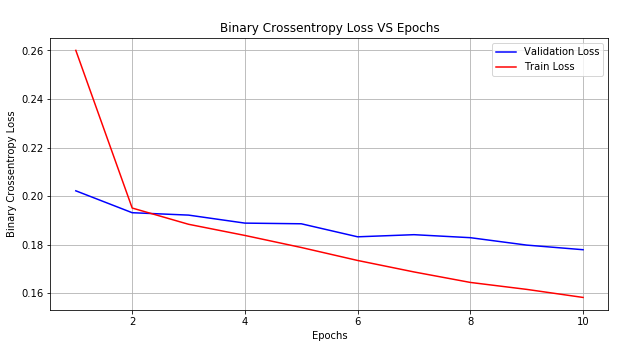

In [42]:
x = list(range(1,11))

# Validation loss
vy = history.history['val_loss']
# Training loss
ty = history.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

##### 2. 2x2 LSTM LAYER

In [45]:
# create the model
embedding_vecor_length = 32
model_2 = Sequential()
model_2.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))

# Add batch normalization
model_2.add(BatchNormalization())

model_2.add(Dropout(0.8))
#First layer
model_2.add(CuDNNLSTM(256,return_sequences=True))
model_2.add(Dropout(0.6))

#Second layer
model_2.add(CuDNNLSTM(128))
model_2.add(Dropout(0.5))


model_2.add(Dense(1, activation='sigmoid'))
print(model_2.summary())

# Compiling the model
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1355, 32)          2291968   
_________________________________________________________________
batch_normalization_6 (Batch (None, 1355, 32)          128       
_________________________________________________________________
dropout_30 (Dropout)         (None, 1355, 32)          0         
_________________________________________________________________
cu_dnnlstm_20 (CuDNNLSTM)    (None, 1355, 256)         296960    
_________________________________________________________________
dropout_31 (Dropout)         (None, 1355, 256)         0         
_________________________________________________________________
cu_dnnlstm_21 (CuDNNLSTM)    (None, 128)               197632    
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
__________

In [46]:
# Fitting the data to the model
history2 = model_2.fit(x_train, y_train, nb_epoch=10, batch_size=256 ,verbose=1,validation_data=(x_test, y_test))

Train on 254919 samples, validate on 109252 samples
Epoch 1/10


 51968/254919 [=====>........................] - ETA: 30:15 - loss: 0.6281 - acc: 0.70 - ETA: 19:52 - loss: 0.5575 - acc: 0.75 - ETA: 16:13 - loss: 0.5239 - acc: 0.78 - ETA: 14:30 - loss: 0.5121 - acc: 0.79 - ETA: 13:25 - loss: 0.4934 - acc: 0.81 - ETA: 12:41 - loss: 0.4918 - acc: 0.81 - ETA: 12:09 - loss: 0.4902 - acc: 0.81 - ETA: 11:44 - loss: 0.4853 - acc: 0.81 - ETA: 11:25 - loss: 0.4775 - acc: 0.82 - ETA: 11:11 - loss: 0.4755 - acc: 0.82 - ETA: 11:00 - loss: 0.4691 - acc: 0.83 - ETA: 10:49 - loss: 0.4692 - acc: 0.83 - ETA: 10:40 - loss: 0.4647 - acc: 0.83 - ETA: 10:31 - loss: 0.4631 - acc: 0.83 - ETA: 10:25 - loss: 0.4587 - acc: 0.83 - ETA: 10:18 - loss: 0.4554 - acc: 0.83 - ETA: 10:14 - loss: 0.4536 - acc: 0.83 - ETA: 10:09 - loss: 0.4493 - acc: 0.84 - ETA: 10:04 - loss: 0.4509 - acc: 0.83 - ETA: 9:59 - loss: 0.4510 - acc: 0.8395 - ETA: 9:56 - loss: 0.4458 - acc: 0.841 - ETA: 9:53 - loss: 0.4433 - acc: 0.843 - ETA: 9:49 - loss: 0.4435 - acc: 0.842 - ETA: 9:46 - loss: 0.4437 - acc

254919/254919 [==============================] - ETA: 1:40 - loss: 0.2687 - acc: 0.893 - ETA: 1:39 - loss: 0.2686 - acc: 0.893 - ETA: 1:39 - loss: 0.2686 - acc: 0.893 - ETA: 1:38 - loss: 0.2685 - acc: 0.893 - ETA: 1:38 - loss: 0.2685 - acc: 0.893 - ETA: 1:37 - loss: 0.2685 - acc: 0.893 - ETA: 1:37 - loss: 0.2683 - acc: 0.893 - ETA: 1:36 - loss: 0.2683 - acc: 0.893 - ETA: 1:35 - loss: 0.2683 - acc: 0.893 - ETA: 1:35 - loss: 0.2682 - acc: 0.893 - ETA: 1:34 - loss: 0.2681 - acc: 0.893 - ETA: 1:34 - loss: 0.2680 - acc: 0.893 - ETA: 1:33 - loss: 0.2681 - acc: 0.893 - ETA: 1:33 - loss: 0.2680 - acc: 0.893 - ETA: 1:32 - loss: 0.2679 - acc: 0.893 - ETA: 1:32 - loss: 0.2678 - acc: 0.893 - ETA: 1:31 - loss: 0.2678 - acc: 0.893 - ETA: 1:30 - loss: 0.2677 - acc: 0.893 - ETA: 1:30 - loss: 0.2677 - acc: 0.893 - ETA: 1:29 - loss: 0.2676 - acc: 0.893 - ETA: 1:29 - loss: 0.2675 - acc: 0.893 - ETA: 1:28 - loss: 0.2675 - acc: 0.893 - ETA: 1:28 - loss: 0.2674 - acc: 0.893 - ETA: 1:27 - loss: 0.2673 - acc:

 52224/254919 [=====>........................] - ETA: 9:10 - loss: 0.1689 - acc: 0.929 - ETA: 9:11 - loss: 0.1889 - acc: 0.916 - ETA: 9:10 - loss: 0.1781 - acc: 0.925 - ETA: 9:11 - loss: 0.1847 - acc: 0.923 - ETA: 9:11 - loss: 0.2062 - acc: 0.913 - ETA: 9:13 - loss: 0.2121 - acc: 0.909 - ETA: 9:12 - loss: 0.2084 - acc: 0.912 - ETA: 9:10 - loss: 0.2101 - acc: 0.910 - ETA: 9:09 - loss: 0.2132 - acc: 0.908 - ETA: 9:08 - loss: 0.2140 - acc: 0.909 - ETA: 9:08 - loss: 0.2146 - acc: 0.910 - ETA: 9:09 - loss: 0.2179 - acc: 0.908 - ETA: 9:11 - loss: 0.2186 - acc: 0.909 - ETA: 9:10 - loss: 0.2199 - acc: 0.907 - ETA: 9:09 - loss: 0.2217 - acc: 0.908 - ETA: 9:07 - loss: 0.2204 - acc: 0.908 - ETA: 9:07 - loss: 0.2169 - acc: 0.910 - ETA: 9:06 - loss: 0.2144 - acc: 0.911 - ETA: 9:05 - loss: 0.2163 - acc: 0.910 - ETA: 9:04 - loss: 0.2151 - acc: 0.911 - ETA: 9:03 - loss: 0.2164 - acc: 0.910 - ETA: 9:02 - loss: 0.2132 - acc: 0.911 - ETA: 9:01 - loss: 0.2134 - acc: 0.912 - ETA: 9:00 - loss: 0.2156 - acc:

254919/254919 [==============================] - ETA: 1:39 - loss: 0.2112 - acc: 0.916 - ETA: 1:38 - loss: 0.2112 - acc: 0.916 - ETA: 1:38 - loss: 0.2112 - acc: 0.916 - ETA: 1:37 - loss: 0.2112 - acc: 0.916 - ETA: 1:37 - loss: 0.2112 - acc: 0.916 - ETA: 1:36 - loss: 0.2111 - acc: 0.916 - ETA: 1:35 - loss: 0.2112 - acc: 0.916 - ETA: 1:35 - loss: 0.2112 - acc: 0.916 - ETA: 1:34 - loss: 0.2111 - acc: 0.916 - ETA: 1:34 - loss: 0.2112 - acc: 0.916 - ETA: 1:33 - loss: 0.2112 - acc: 0.916 - ETA: 1:33 - loss: 0.2112 - acc: 0.916 - ETA: 1:32 - loss: 0.2112 - acc: 0.916 - ETA: 1:32 - loss: 0.2113 - acc: 0.916 - ETA: 1:31 - loss: 0.2113 - acc: 0.916 - ETA: 1:30 - loss: 0.2113 - acc: 0.916 - ETA: 1:30 - loss: 0.2112 - acc: 0.916 - ETA: 1:29 - loss: 0.2111 - acc: 0.916 - ETA: 1:29 - loss: 0.2111 - acc: 0.916 - ETA: 1:28 - loss: 0.2112 - acc: 0.916 - ETA: 1:28 - loss: 0.2112 - acc: 0.916 - ETA: 1:27 - loss: 0.2112 - acc: 0.916 - ETA: 1:27 - loss: 0.2113 - acc: 0.916 - ETA: 1:26 - loss: 0.2113 - acc:

 52224/254919 [=====>........................] - ETA: 9:02 - loss: 0.2395 - acc: 0.902 - ETA: 9:03 - loss: 0.2204 - acc: 0.914 - ETA: 9:03 - loss: 0.2159 - acc: 0.915 - ETA: 9:04 - loss: 0.2093 - acc: 0.920 - ETA: 9:03 - loss: 0.2060 - acc: 0.922 - ETA: 9:03 - loss: 0.2019 - acc: 0.922 - ETA: 9:03 - loss: 0.2053 - acc: 0.921 - ETA: 9:02 - loss: 0.2021 - acc: 0.920 - ETA: 9:02 - loss: 0.1953 - acc: 0.924 - ETA: 9:01 - loss: 0.2001 - acc: 0.921 - ETA: 9:02 - loss: 0.1967 - acc: 0.922 - ETA: 9:02 - loss: 0.1942 - acc: 0.922 - ETA: 9:02 - loss: 0.1954 - acc: 0.923 - ETA: 9:02 - loss: 0.1966 - acc: 0.921 - ETA: 9:01 - loss: 0.1973 - acc: 0.921 - ETA: 9:00 - loss: 0.1988 - acc: 0.920 - ETA: 9:01 - loss: 0.2006 - acc: 0.920 - ETA: 9:00 - loss: 0.2025 - acc: 0.920 - ETA: 9:00 - loss: 0.1986 - acc: 0.921 - ETA: 9:00 - loss: 0.1961 - acc: 0.922 - ETA: 8:59 - loss: 0.1972 - acc: 0.922 - ETA: 8:57 - loss: 0.1980 - acc: 0.922 - ETA: 8:56 - loss: 0.1972 - acc: 0.922 - ETA: 8:56 - loss: 0.1985 - acc:

254919/254919 [==============================] - ETA: 1:39 - loss: 0.2014 - acc: 0.920 - ETA: 1:38 - loss: 0.2014 - acc: 0.920 - ETA: 1:37 - loss: 0.2015 - acc: 0.920 - ETA: 1:37 - loss: 0.2014 - acc: 0.920 - ETA: 1:36 - loss: 0.2014 - acc: 0.920 - ETA: 1:36 - loss: 0.2014 - acc: 0.920 - ETA: 1:35 - loss: 0.2014 - acc: 0.920 - ETA: 1:35 - loss: 0.2014 - acc: 0.920 - ETA: 1:34 - loss: 0.2014 - acc: 0.920 - ETA: 1:34 - loss: 0.2014 - acc: 0.920 - ETA: 1:33 - loss: 0.2014 - acc: 0.920 - ETA: 1:32 - loss: 0.2014 - acc: 0.920 - ETA: 1:32 - loss: 0.2014 - acc: 0.920 - ETA: 1:31 - loss: 0.2014 - acc: 0.920 - ETA: 1:31 - loss: 0.2014 - acc: 0.920 - ETA: 1:30 - loss: 0.2015 - acc: 0.920 - ETA: 1:30 - loss: 0.2015 - acc: 0.920 - ETA: 1:29 - loss: 0.2015 - acc: 0.920 - ETA: 1:29 - loss: 0.2015 - acc: 0.920 - ETA: 1:28 - loss: 0.2016 - acc: 0.920 - ETA: 1:27 - loss: 0.2016 - acc: 0.920 - ETA: 1:27 - loss: 0.2015 - acc: 0.920 - ETA: 1:26 - loss: 0.2015 - acc: 0.920 - ETA: 1:26 - loss: 0.2015 - acc:

 52224/254919 [=====>........................] - ETA: 9:12 - loss: 0.2163 - acc: 0.910 - ETA: 9:18 - loss: 0.1985 - acc: 0.919 - ETA: 9:14 - loss: 0.2059 - acc: 0.914 - ETA: 9:12 - loss: 0.2230 - acc: 0.909 - ETA: 9:12 - loss: 0.2080 - acc: 0.915 - ETA: 9:11 - loss: 0.2022 - acc: 0.921 - ETA: 9:09 - loss: 0.1985 - acc: 0.922 - ETA: 9:08 - loss: 0.1967 - acc: 0.922 - ETA: 9:07 - loss: 0.1895 - acc: 0.924 - ETA: 9:06 - loss: 0.1945 - acc: 0.922 - ETA: 9:07 - loss: 0.1917 - acc: 0.923 - ETA: 9:06 - loss: 0.1901 - acc: 0.924 - ETA: 9:05 - loss: 0.1884 - acc: 0.925 - ETA: 9:04 - loss: 0.1905 - acc: 0.924 - ETA: 9:03 - loss: 0.1928 - acc: 0.924 - ETA: 9:02 - loss: 0.1924 - acc: 0.924 - ETA: 9:02 - loss: 0.1878 - acc: 0.926 - ETA: 9:02 - loss: 0.1882 - acc: 0.926 - ETA: 9:02 - loss: 0.1894 - acc: 0.926 - ETA: 9:01 - loss: 0.1889 - acc: 0.925 - ETA: 9:00 - loss: 0.1916 - acc: 0.924 - ETA: 9:00 - loss: 0.1918 - acc: 0.924 - ETA: 8:59 - loss: 0.1940 - acc: 0.922 - ETA: 8:58 - loss: 0.1958 - acc:

254919/254919 [==============================] - ETA: 1:39 - loss: 0.1958 - acc: 0.922 - ETA: 1:38 - loss: 0.1958 - acc: 0.922 - ETA: 1:38 - loss: 0.1958 - acc: 0.922 - ETA: 1:37 - loss: 0.1958 - acc: 0.922 - ETA: 1:36 - loss: 0.1958 - acc: 0.922 - ETA: 1:36 - loss: 0.1958 - acc: 0.922 - ETA: 1:35 - loss: 0.1958 - acc: 0.922 - ETA: 1:35 - loss: 0.1959 - acc: 0.922 - ETA: 1:34 - loss: 0.1959 - acc: 0.922 - ETA: 1:34 - loss: 0.1959 - acc: 0.922 - ETA: 1:33 - loss: 0.1959 - acc: 0.922 - ETA: 1:33 - loss: 0.1958 - acc: 0.922 - ETA: 1:32 - loss: 0.1959 - acc: 0.922 - ETA: 1:32 - loss: 0.1959 - acc: 0.922 - ETA: 1:31 - loss: 0.1959 - acc: 0.922 - ETA: 1:30 - loss: 0.1959 - acc: 0.922 - ETA: 1:30 - loss: 0.1959 - acc: 0.922 - ETA: 1:29 - loss: 0.1959 - acc: 0.922 - ETA: 1:29 - loss: 0.1958 - acc: 0.922 - ETA: 1:28 - loss: 0.1958 - acc: 0.922 - ETA: 1:28 - loss: 0.1958 - acc: 0.922 - ETA: 1:27 - loss: 0.1958 - acc: 0.922 - ETA: 1:27 - loss: 0.1958 - acc: 0.922 - ETA: 1:26 - loss: 0.1958 - acc:

 52224/254919 [=====>........................] - ETA: 9:13 - loss: 0.1854 - acc: 0.918 - ETA: 9:13 - loss: 0.2152 - acc: 0.902 - ETA: 9:10 - loss: 0.2132 - acc: 0.904 - ETA: 9:08 - loss: 0.2132 - acc: 0.899 - ETA: 9:08 - loss: 0.2111 - acc: 0.902 - ETA: 9:09 - loss: 0.2027 - acc: 0.909 - ETA: 9:08 - loss: 0.1994 - acc: 0.911 - ETA: 9:07 - loss: 0.1935 - acc: 0.915 - ETA: 9:06 - loss: 0.1862 - acc: 0.919 - ETA: 9:07 - loss: 0.1857 - acc: 0.919 - ETA: 9:07 - loss: 0.1843 - acc: 0.919 - ETA: 9:06 - loss: 0.1814 - acc: 0.921 - ETA: 9:05 - loss: 0.1797 - acc: 0.923 - ETA: 9:05 - loss: 0.1762 - acc: 0.925 - ETA: 9:05 - loss: 0.1808 - acc: 0.922 - ETA: 9:04 - loss: 0.1816 - acc: 0.923 - ETA: 9:03 - loss: 0.1829 - acc: 0.922 - ETA: 9:02 - loss: 0.1828 - acc: 0.923 - ETA: 9:01 - loss: 0.1837 - acc: 0.922 - ETA: 9:01 - loss: 0.1864 - acc: 0.921 - ETA: 9:01 - loss: 0.1863 - acc: 0.922 - ETA: 9:00 - loss: 0.1897 - acc: 0.921 - ETA: 8:59 - loss: 0.1885 - acc: 0.922 - ETA: 8:59 - loss: 0.1884 - acc:

254919/254919 [==============================] - ETA: 1:39 - loss: 0.1918 - acc: 0.924 - ETA: 1:38 - loss: 0.1918 - acc: 0.924 - ETA: 1:38 - loss: 0.1917 - acc: 0.924 - ETA: 1:37 - loss: 0.1917 - acc: 0.924 - ETA: 1:37 - loss: 0.1917 - acc: 0.924 - ETA: 1:36 - loss: 0.1917 - acc: 0.924 - ETA: 1:35 - loss: 0.1917 - acc: 0.924 - ETA: 1:35 - loss: 0.1917 - acc: 0.924 - ETA: 1:34 - loss: 0.1917 - acc: 0.924 - ETA: 1:34 - loss: 0.1916 - acc: 0.924 - ETA: 1:33 - loss: 0.1916 - acc: 0.924 - ETA: 1:33 - loss: 0.1916 - acc: 0.924 - ETA: 1:32 - loss: 0.1916 - acc: 0.924 - ETA: 1:32 - loss: 0.1917 - acc: 0.924 - ETA: 1:31 - loss: 0.1916 - acc: 0.924 - ETA: 1:30 - loss: 0.1916 - acc: 0.924 - ETA: 1:30 - loss: 0.1916 - acc: 0.924 - ETA: 1:29 - loss: 0.1916 - acc: 0.924 - ETA: 1:29 - loss: 0.1916 - acc: 0.924 - ETA: 1:28 - loss: 0.1916 - acc: 0.924 - ETA: 1:28 - loss: 0.1915 - acc: 0.924 - ETA: 1:27 - loss: 0.1915 - acc: 0.924 - ETA: 1:27 - loss: 0.1914 - acc: 0.924 - ETA: 1:26 - loss: 0.1914 - acc:

 52224/254919 [=====>........................] - ETA: 9:00 - loss: 0.2998 - acc: 0.906 - ETA: 9:04 - loss: 0.2298 - acc: 0.916 - ETA: 9:09 - loss: 0.2050 - acc: 0.920 - ETA: 9:12 - loss: 0.1953 - acc: 0.926 - ETA: 9:10 - loss: 0.2003 - acc: 0.921 - ETA: 9:10 - loss: 0.1929 - acc: 0.923 - ETA: 9:10 - loss: 0.1918 - acc: 0.923 - ETA: 9:07 - loss: 0.1921 - acc: 0.922 - ETA: 9:08 - loss: 0.1903 - acc: 0.921 - ETA: 9:07 - loss: 0.1884 - acc: 0.923 - ETA: 9:06 - loss: 0.1876 - acc: 0.925 - ETA: 9:06 - loss: 0.1830 - acc: 0.927 - ETA: 9:05 - loss: 0.1865 - acc: 0.928 - ETA: 9:04 - loss: 0.1862 - acc: 0.927 - ETA: 9:03 - loss: 0.1875 - acc: 0.926 - ETA: 9:03 - loss: 0.1904 - acc: 0.924 - ETA: 9:02 - loss: 0.1914 - acc: 0.924 - ETA: 9:02 - loss: 0.1909 - acc: 0.924 - ETA: 9:02 - loss: 0.1887 - acc: 0.925 - ETA: 9:01 - loss: 0.1892 - acc: 0.924 - ETA: 9:01 - loss: 0.1891 - acc: 0.925 - ETA: 9:01 - loss: 0.1894 - acc: 0.924 - ETA: 9:00 - loss: 0.1880 - acc: 0.925 - ETA: 8:59 - loss: 0.1878 - acc:

254919/254919 [==============================] - ETA: 1:39 - loss: 0.1887 - acc: 0.925 - ETA: 1:38 - loss: 0.1886 - acc: 0.925 - ETA: 1:38 - loss: 0.1887 - acc: 0.925 - ETA: 1:37 - loss: 0.1886 - acc: 0.925 - ETA: 1:36 - loss: 0.1886 - acc: 0.925 - ETA: 1:36 - loss: 0.1886 - acc: 0.925 - ETA: 1:35 - loss: 0.1887 - acc: 0.925 - ETA: 1:35 - loss: 0.1887 - acc: 0.925 - ETA: 1:34 - loss: 0.1888 - acc: 0.925 - ETA: 1:34 - loss: 0.1888 - acc: 0.925 - ETA: 1:33 - loss: 0.1888 - acc: 0.925 - ETA: 1:33 - loss: 0.1888 - acc: 0.925 - ETA: 1:32 - loss: 0.1888 - acc: 0.925 - ETA: 1:31 - loss: 0.1887 - acc: 0.925 - ETA: 1:31 - loss: 0.1887 - acc: 0.925 - ETA: 1:30 - loss: 0.1887 - acc: 0.925 - ETA: 1:30 - loss: 0.1887 - acc: 0.925 - ETA: 1:29 - loss: 0.1887 - acc: 0.925 - ETA: 1:29 - loss: 0.1888 - acc: 0.925 - ETA: 1:28 - loss: 0.1888 - acc: 0.925 - ETA: 1:28 - loss: 0.1888 - acc: 0.925 - ETA: 1:27 - loss: 0.1887 - acc: 0.925 - ETA: 1:26 - loss: 0.1887 - acc: 0.925 - ETA: 1:26 - loss: 0.1887 - acc:

 52224/254919 [=====>........................] - ETA: 9:01 - loss: 0.1499 - acc: 0.941 - ETA: 9:06 - loss: 0.1734 - acc: 0.929 - ETA: 9:05 - loss: 0.1823 - acc: 0.920 - ETA: 9:09 - loss: 0.1848 - acc: 0.920 - ETA: 9:08 - loss: 0.1867 - acc: 0.921 - ETA: 9:09 - loss: 0.1807 - acc: 0.923 - ETA: 9:08 - loss: 0.1817 - acc: 0.926 - ETA: 9:07 - loss: 0.1760 - acc: 0.929 - ETA: 9:05 - loss: 0.1719 - acc: 0.930 - ETA: 9:05 - loss: 0.1697 - acc: 0.932 - ETA: 9:04 - loss: 0.1727 - acc: 0.930 - ETA: 9:05 - loss: 0.1699 - acc: 0.931 - ETA: 9:04 - loss: 0.1658 - acc: 0.933 - ETA: 9:04 - loss: 0.1677 - acc: 0.932 - ETA: 9:04 - loss: 0.1693 - acc: 0.930 - ETA: 9:02 - loss: 0.1681 - acc: 0.931 - ETA: 9:02 - loss: 0.1684 - acc: 0.931 - ETA: 9:02 - loss: 0.1688 - acc: 0.931 - ETA: 9:01 - loss: 0.1686 - acc: 0.931 - ETA: 9:01 - loss: 0.1707 - acc: 0.930 - ETA: 9:00 - loss: 0.1725 - acc: 0.930 - ETA: 8:59 - loss: 0.1737 - acc: 0.930 - ETA: 8:58 - loss: 0.1756 - acc: 0.929 - ETA: 8:58 - loss: 0.1767 - acc:

254919/254919 [==============================] - ETA: 1:39 - loss: 0.1865 - acc: 0.926 - ETA: 1:38 - loss: 0.1864 - acc: 0.926 - ETA: 1:38 - loss: 0.1864 - acc: 0.926 - ETA: 1:37 - loss: 0.1864 - acc: 0.926 - ETA: 1:37 - loss: 0.1863 - acc: 0.926 - ETA: 1:36 - loss: 0.1863 - acc: 0.926 - ETA: 1:35 - loss: 0.1863 - acc: 0.926 - ETA: 1:35 - loss: 0.1863 - acc: 0.926 - ETA: 1:34 - loss: 0.1863 - acc: 0.926 - ETA: 1:34 - loss: 0.1863 - acc: 0.926 - ETA: 1:33 - loss: 0.1862 - acc: 0.926 - ETA: 1:33 - loss: 0.1861 - acc: 0.926 - ETA: 1:32 - loss: 0.1861 - acc: 0.926 - ETA: 1:32 - loss: 0.1861 - acc: 0.926 - ETA: 1:31 - loss: 0.1862 - acc: 0.926 - ETA: 1:30 - loss: 0.1862 - acc: 0.926 - ETA: 1:30 - loss: 0.1863 - acc: 0.926 - ETA: 1:29 - loss: 0.1863 - acc: 0.926 - ETA: 1:29 - loss: 0.1863 - acc: 0.926 - ETA: 1:28 - loss: 0.1862 - acc: 0.926 - ETA: 1:28 - loss: 0.1862 - acc: 0.926 - ETA: 1:27 - loss: 0.1862 - acc: 0.926 - ETA: 1:27 - loss: 0.1863 - acc: 0.926 - ETA: 1:26 - loss: 0.1863 - acc:

 52224/254919 [=====>........................] - ETA: 9:10 - loss: 0.2086 - acc: 0.914 - ETA: 9:06 - loss: 0.2064 - acc: 0.919 - ETA: 9:07 - loss: 0.1892 - acc: 0.923 - ETA: 9:09 - loss: 0.1942 - acc: 0.918 - ETA: 9:08 - loss: 0.1875 - acc: 0.921 - ETA: 9:07 - loss: 0.1930 - acc: 0.919 - ETA: 9:08 - loss: 0.1894 - acc: 0.922 - ETA: 9:07 - loss: 0.1848 - acc: 0.923 - ETA: 9:08 - loss: 0.1833 - acc: 0.925 - ETA: 9:07 - loss: 0.1811 - acc: 0.926 - ETA: 9:06 - loss: 0.1794 - acc: 0.927 - ETA: 9:05 - loss: 0.1817 - acc: 0.927 - ETA: 9:04 - loss: 0.1791 - acc: 0.929 - ETA: 9:03 - loss: 0.1791 - acc: 0.930 - ETA: 9:03 - loss: 0.1802 - acc: 0.929 - ETA: 9:02 - loss: 0.1780 - acc: 0.930 - ETA: 9:02 - loss: 0.1768 - acc: 0.929 - ETA: 9:01 - loss: 0.1772 - acc: 0.929 - ETA: 9:01 - loss: 0.1761 - acc: 0.929 - ETA: 9:01 - loss: 0.1764 - acc: 0.930 - ETA: 9:00 - loss: 0.1762 - acc: 0.929 - ETA: 8:59 - loss: 0.1766 - acc: 0.930 - ETA: 8:59 - loss: 0.1770 - acc: 0.930 - ETA: 8:58 - loss: 0.1768 - acc:

254919/254919 [==============================] - ETA: 1:39 - loss: 0.1851 - acc: 0.926 - ETA: 1:38 - loss: 0.1850 - acc: 0.927 - ETA: 1:38 - loss: 0.1850 - acc: 0.927 - ETA: 1:37 - loss: 0.1850 - acc: 0.927 - ETA: 1:36 - loss: 0.1849 - acc: 0.927 - ETA: 1:36 - loss: 0.1849 - acc: 0.927 - ETA: 1:35 - loss: 0.1849 - acc: 0.927 - ETA: 1:35 - loss: 0.1849 - acc: 0.927 - ETA: 1:34 - loss: 0.1849 - acc: 0.927 - ETA: 1:34 - loss: 0.1848 - acc: 0.927 - ETA: 1:33 - loss: 0.1848 - acc: 0.927 - ETA: 1:33 - loss: 0.1849 - acc: 0.927 - ETA: 1:32 - loss: 0.1849 - acc: 0.927 - ETA: 1:31 - loss: 0.1849 - acc: 0.927 - ETA: 1:31 - loss: 0.1850 - acc: 0.927 - ETA: 1:30 - loss: 0.1850 - acc: 0.927 - ETA: 1:30 - loss: 0.1849 - acc: 0.927 - ETA: 1:29 - loss: 0.1850 - acc: 0.927 - ETA: 1:29 - loss: 0.1850 - acc: 0.927 - ETA: 1:28 - loss: 0.1850 - acc: 0.927 - ETA: 1:28 - loss: 0.1851 - acc: 0.927 - ETA: 1:27 - loss: 0.1850 - acc: 0.927 - ETA: 1:26 - loss: 0.1850 - acc: 0.927 - ETA: 1:26 - loss: 0.1850 - acc:

 52224/254919 [=====>........................] - ETA: 9:06 - loss: 0.1696 - acc: 0.941 - ETA: 9:07 - loss: 0.1797 - acc: 0.939 - ETA: 9:07 - loss: 0.1806 - acc: 0.933 - ETA: 9:13 - loss: 0.1805 - acc: 0.928 - ETA: 9:12 - loss: 0.1860 - acc: 0.924 - ETA: 9:10 - loss: 0.1775 - acc: 0.926 - ETA: 9:09 - loss: 0.1824 - acc: 0.925 - ETA: 9:08 - loss: 0.1846 - acc: 0.926 - ETA: 9:08 - loss: 0.1838 - acc: 0.926 - ETA: 9:07 - loss: 0.1868 - acc: 0.923 - ETA: 9:06 - loss: 0.1885 - acc: 0.922 - ETA: 9:07 - loss: 0.1916 - acc: 0.923 - ETA: 9:06 - loss: 0.1854 - acc: 0.925 - ETA: 9:05 - loss: 0.1864 - acc: 0.925 - ETA: 9:04 - loss: 0.1839 - acc: 0.926 - ETA: 9:03 - loss: 0.1850 - acc: 0.927 - ETA: 9:02 - loss: 0.1833 - acc: 0.927 - ETA: 9:03 - loss: 0.1845 - acc: 0.927 - ETA: 9:02 - loss: 0.1853 - acc: 0.926 - ETA: 9:02 - loss: 0.1852 - acc: 0.926 - ETA: 9:01 - loss: 0.1872 - acc: 0.925 - ETA: 9:00 - loss: 0.1861 - acc: 0.925 - ETA: 8:59 - loss: 0.1858 - acc: 0.925 - ETA: 8:59 - loss: 0.1868 - acc:

254919/254919 [==============================] - ETA: 1:39 - loss: 0.1831 - acc: 0.927 - ETA: 1:38 - loss: 0.1831 - acc: 0.927 - ETA: 1:38 - loss: 0.1831 - acc: 0.927 - ETA: 1:37 - loss: 0.1831 - acc: 0.927 - ETA: 1:37 - loss: 0.1831 - acc: 0.927 - ETA: 1:36 - loss: 0.1831 - acc: 0.927 - ETA: 1:35 - loss: 0.1832 - acc: 0.927 - ETA: 1:35 - loss: 0.1831 - acc: 0.927 - ETA: 1:34 - loss: 0.1832 - acc: 0.927 - ETA: 1:34 - loss: 0.1832 - acc: 0.927 - ETA: 1:33 - loss: 0.1832 - acc: 0.927 - ETA: 1:33 - loss: 0.1831 - acc: 0.927 - ETA: 1:32 - loss: 0.1831 - acc: 0.927 - ETA: 1:32 - loss: 0.1831 - acc: 0.927 - ETA: 1:31 - loss: 0.1832 - acc: 0.927 - ETA: 1:30 - loss: 0.1831 - acc: 0.927 - ETA: 1:30 - loss: 0.1831 - acc: 0.927 - ETA: 1:29 - loss: 0.1831 - acc: 0.927 - ETA: 1:29 - loss: 0.1831 - acc: 0.927 - ETA: 1:28 - loss: 0.1831 - acc: 0.927 - ETA: 1:28 - loss: 0.1831 - acc: 0.927 - ETA: 1:27 - loss: 0.1831 - acc: 0.927 - ETA: 1:27 - loss: 0.1831 - acc: 0.927 - ETA: 1:26 - loss: 0.1832 - acc:

 52224/254919 [=====>........................] - ETA: 9:14 - loss: 0.1992 - acc: 0.918 - ETA: 9:11 - loss: 0.1867 - acc: 0.927 - ETA: 9:08 - loss: 0.1821 - acc: 0.932 - ETA: 9:09 - loss: 0.1791 - acc: 0.931 - ETA: 9:08 - loss: 0.1832 - acc: 0.935 - ETA: 9:08 - loss: 0.1853 - acc: 0.932 - ETA: 9:07 - loss: 0.1791 - acc: 0.933 - ETA: 9:06 - loss: 0.1751 - acc: 0.934 - ETA: 9:04 - loss: 0.1784 - acc: 0.932 - ETA: 9:03 - loss: 0.1832 - acc: 0.931 - ETA: 9:04 - loss: 0.1830 - acc: 0.931 - ETA: 9:04 - loss: 0.1866 - acc: 0.929 - ETA: 9:04 - loss: 0.1878 - acc: 0.927 - ETA: 9:03 - loss: 0.1821 - acc: 0.930 - ETA: 9:02 - loss: 0.1814 - acc: 0.930 - ETA: 9:02 - loss: 0.1819 - acc: 0.929 - ETA: 9:02 - loss: 0.1809 - acc: 0.929 - ETA: 9:02 - loss: 0.1785 - acc: 0.930 - ETA: 9:01 - loss: 0.1796 - acc: 0.930 - ETA: 9:01 - loss: 0.1791 - acc: 0.930 - ETA: 9:00 - loss: 0.1797 - acc: 0.930 - ETA: 9:00 - loss: 0.1807 - acc: 0.929 - ETA: 8:59 - loss: 0.1805 - acc: 0.929 - ETA: 8:58 - loss: 0.1804 - acc:

254919/254919 [==============================] - ETA: 1:39 - loss: 0.1816 - acc: 0.928 - ETA: 1:38 - loss: 0.1817 - acc: 0.928 - ETA: 1:38 - loss: 0.1816 - acc: 0.928 - ETA: 1:37 - loss: 0.1816 - acc: 0.928 - ETA: 1:36 - loss: 0.1816 - acc: 0.928 - ETA: 1:36 - loss: 0.1815 - acc: 0.928 - ETA: 1:35 - loss: 0.1815 - acc: 0.928 - ETA: 1:35 - loss: 0.1815 - acc: 0.928 - ETA: 1:34 - loss: 0.1816 - acc: 0.928 - ETA: 1:34 - loss: 0.1815 - acc: 0.928 - ETA: 1:33 - loss: 0.1815 - acc: 0.928 - ETA: 1:33 - loss: 0.1815 - acc: 0.928 - ETA: 1:32 - loss: 0.1815 - acc: 0.928 - ETA: 1:31 - loss: 0.1815 - acc: 0.928 - ETA: 1:31 - loss: 0.1815 - acc: 0.928 - ETA: 1:30 - loss: 0.1815 - acc: 0.928 - ETA: 1:30 - loss: 0.1815 - acc: 0.928 - ETA: 1:29 - loss: 0.1815 - acc: 0.928 - ETA: 1:29 - loss: 0.1814 - acc: 0.928 - ETA: 1:28 - loss: 0.1814 - acc: 0.928 - ETA: 1:28 - loss: 0.1814 - acc: 0.928 - ETA: 1:27 - loss: 0.1814 - acc: 0.928 - ETA: 1:26 - loss: 0.1814 - acc: 0.928 - ETA: 1:26 - loss: 0.1814 - acc:

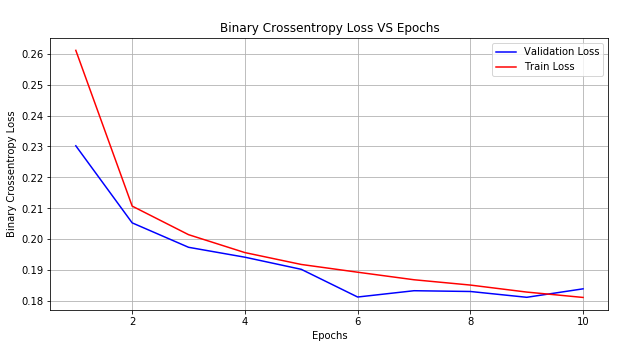

In [47]:
x = list(range(1,11))

# Validation loss
vy = history2.history['val_loss']
# Training loss
ty = history2.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

##### 3. 3x3 LSTM LAYER

In [48]:
# create the model
embedding_vecor_length = 32
model_3 = Sequential()

model_3.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))

# Add batch normalization
model_3.add(BatchNormalization())

model_3.add(Dropout(0.8))
#First layer
model_3.add(CuDNNLSTM(256,return_sequences=True))
model_3.add(Dropout(0.6))

#Second layer
model_3.add(CuDNNLSTM(128,return_sequences=True))
model_3.add(Dropout(0.5))

#Third layer
model_3.add(CuDNNLSTM(64))
model_3.add(Dropout(0.3))

model_3.add(Dense(1, activation='sigmoid'))
print(model_3.summary())

# Compiling the model
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1355, 32)          2291968   
_________________________________________________________________
batch_normalization_7 (Batch (None, 1355, 32)          128       
_________________________________________________________________
dropout_33 (Dropout)         (None, 1355, 32)          0         
_________________________________________________________________
cu_dnnlstm_22 (CuDNNLSTM)    (None, 1355, 256)         296960    
_________________________________________________________________
dropout_34 (Dropout)         (None, 1355, 256)         0         
_________________________________________________________________
cu_dnnlstm_23 (CuDNNLSTM)    (None, 1355, 128)         197632    
_________________________________________________________________
dropout_35 (Dropout)         (None, 1355, 128)         0         
__________

In [49]:
# Fitting the data to the model
history3 = model_3.fit(x_train, y_train, nb_epoch=10, batch_size=256 ,verbose=1,validation_data=(x_test, y_test))

Train on 254919 samples, validate on 109252 samples
Epoch 1/10


 51968/254919 [=====>........................] - ETA: 35:10 - loss: 0.6851 - acc: 0.55 - ETA: 23:04 - loss: 0.5992 - acc: 0.70 - ETA: 18:50 - loss: 0.5608 - acc: 0.74 - ETA: 16:48 - loss: 0.5322 - acc: 0.77 - ETA: 15:34 - loss: 0.5194 - acc: 0.78 - ETA: 14:47 - loss: 0.5110 - acc: 0.79 - ETA: 14:08 - loss: 0.5060 - acc: 0.79 - ETA: 13:41 - loss: 0.4934 - acc: 0.80 - ETA: 13:20 - loss: 0.4918 - acc: 0.80 - ETA: 13:04 - loss: 0.4878 - acc: 0.81 - ETA: 12:48 - loss: 0.4842 - acc: 0.81 - ETA: 12:38 - loss: 0.4838 - acc: 0.81 - ETA: 12:28 - loss: 0.4810 - acc: 0.81 - ETA: 12:19 - loss: 0.4779 - acc: 0.81 - ETA: 12:10 - loss: 0.4734 - acc: 0.82 - ETA: 12:04 - loss: 0.4751 - acc: 0.82 - ETA: 11:58 - loss: 0.4722 - acc: 0.82 - ETA: 11:52 - loss: 0.4716 - acc: 0.82 - ETA: 11:48 - loss: 0.4684 - acc: 0.82 - ETA: 11:43 - loss: 0.4655 - acc: 0.82 - ETA: 11:39 - loss: 0.4661 - acc: 0.82 - ETA: 11:35 - loss: 0.4630 - acc: 0.82 - ETA: 11:32 - loss: 0.4630 - acc: 0.82 - ETA: 11:28 - loss: 0.4629 - acc

254919/254919 [==============================] - ETA: 1:56 - loss: 0.2663 - acc: 0.893 - ETA: 1:55 - loss: 0.2663 - acc: 0.893 - ETA: 1:55 - loss: 0.2663 - acc: 0.894 - ETA: 1:54 - loss: 0.2661 - acc: 0.894 - ETA: 1:53 - loss: 0.2660 - acc: 0.894 - ETA: 1:53 - loss: 0.2659 - acc: 0.894 - ETA: 1:52 - loss: 0.2658 - acc: 0.894 - ETA: 1:52 - loss: 0.2658 - acc: 0.894 - ETA: 1:51 - loss: 0.2658 - acc: 0.894 - ETA: 1:50 - loss: 0.2658 - acc: 0.894 - ETA: 1:50 - loss: 0.2658 - acc: 0.894 - ETA: 1:49 - loss: 0.2658 - acc: 0.894 - ETA: 1:48 - loss: 0.2657 - acc: 0.894 - ETA: 1:48 - loss: 0.2656 - acc: 0.894 - ETA: 1:47 - loss: 0.2656 - acc: 0.894 - ETA: 1:46 - loss: 0.2655 - acc: 0.894 - ETA: 1:46 - loss: 0.2655 - acc: 0.894 - ETA: 1:45 - loss: 0.2655 - acc: 0.894 - ETA: 1:44 - loss: 0.2654 - acc: 0.894 - ETA: 1:44 - loss: 0.2654 - acc: 0.894 - ETA: 1:43 - loss: 0.2654 - acc: 0.894 - ETA: 1:42 - loss: 0.2654 - acc: 0.894 - ETA: 1:42 - loss: 0.2654 - acc: 0.894 - ETA: 1:41 - loss: 0.2653 - acc:

 52224/254919 [=====>........................] - ETA: 10:47 - loss: 0.2267 - acc: 0.90 - ETA: 10:48 - loss: 0.1974 - acc: 0.91 - ETA: 10:42 - loss: 0.2106 - acc: 0.91 - ETA: 10:42 - loss: 0.2139 - acc: 0.91 - ETA: 10:42 - loss: 0.2154 - acc: 0.91 - ETA: 10:42 - loss: 0.2110 - acc: 0.91 - ETA: 10:40 - loss: 0.2091 - acc: 0.91 - ETA: 10:41 - loss: 0.2140 - acc: 0.91 - ETA: 10:39 - loss: 0.2112 - acc: 0.91 - ETA: 10:38 - loss: 0.2118 - acc: 0.91 - ETA: 10:38 - loss: 0.2101 - acc: 0.91 - ETA: 10:37 - loss: 0.2131 - acc: 0.91 - ETA: 10:36 - loss: 0.2109 - acc: 0.91 - ETA: 10:35 - loss: 0.2108 - acc: 0.91 - ETA: 10:34 - loss: 0.2114 - acc: 0.91 - ETA: 10:33 - loss: 0.2107 - acc: 0.91 - ETA: 10:33 - loss: 0.2092 - acc: 0.91 - ETA: 10:31 - loss: 0.2098 - acc: 0.91 - ETA: 10:31 - loss: 0.2100 - acc: 0.91 - ETA: 10:31 - loss: 0.2119 - acc: 0.91 - ETA: 10:30 - loss: 0.2121 - acc: 0.91 - ETA: 10:29 - loss: 0.2116 - acc: 0.91 - ETA: 10:28 - loss: 0.2126 - acc: 0.91 - ETA: 10:28 - loss: 0.2130 - acc

254919/254919 [==============================] - ETA: 1:55 - loss: 0.2079 - acc: 0.917 - ETA: 1:55 - loss: 0.2079 - acc: 0.917 - ETA: 1:54 - loss: 0.2080 - acc: 0.917 - ETA: 1:53 - loss: 0.2079 - acc: 0.917 - ETA: 1:53 - loss: 0.2079 - acc: 0.917 - ETA: 1:52 - loss: 0.2080 - acc: 0.917 - ETA: 1:51 - loss: 0.2079 - acc: 0.917 - ETA: 1:51 - loss: 0.2079 - acc: 0.917 - ETA: 1:50 - loss: 0.2079 - acc: 0.917 - ETA: 1:49 - loss: 0.2079 - acc: 0.917 - ETA: 1:49 - loss: 0.2079 - acc: 0.917 - ETA: 1:48 - loss: 0.2079 - acc: 0.917 - ETA: 1:47 - loss: 0.2080 - acc: 0.917 - ETA: 1:47 - loss: 0.2080 - acc: 0.917 - ETA: 1:46 - loss: 0.2080 - acc: 0.917 - ETA: 1:46 - loss: 0.2080 - acc: 0.917 - ETA: 1:45 - loss: 0.2081 - acc: 0.917 - ETA: 1:44 - loss: 0.2080 - acc: 0.917 - ETA: 1:44 - loss: 0.2081 - acc: 0.917 - ETA: 1:43 - loss: 0.2081 - acc: 0.917 - ETA: 1:42 - loss: 0.2082 - acc: 0.917 - ETA: 1:42 - loss: 0.2082 - acc: 0.917 - ETA: 1:41 - loss: 0.2082 - acc: 0.917 - ETA: 1:40 - loss: 0.2082 - acc:

 52224/254919 [=====>........................] - ETA: 10:52 - loss: 0.1966 - acc: 0.91 - ETA: 10:48 - loss: 0.2285 - acc: 0.90 - ETA: 10:42 - loss: 0.2201 - acc: 0.91 - ETA: 10:46 - loss: 0.2193 - acc: 0.91 - ETA: 10:45 - loss: 0.2164 - acc: 0.91 - ETA: 10:45 - loss: 0.2134 - acc: 0.91 - ETA: 10:41 - loss: 0.2099 - acc: 0.91 - ETA: 10:41 - loss: 0.2111 - acc: 0.91 - ETA: 10:40 - loss: 0.2073 - acc: 0.91 - ETA: 10:40 - loss: 0.2116 - acc: 0.91 - ETA: 10:38 - loss: 0.2145 - acc: 0.91 - ETA: 10:37 - loss: 0.2101 - acc: 0.91 - ETA: 10:36 - loss: 0.2034 - acc: 0.91 - ETA: 10:35 - loss: 0.2025 - acc: 0.91 - ETA: 10:35 - loss: 0.2003 - acc: 0.91 - ETA: 10:35 - loss: 0.1984 - acc: 0.91 - ETA: 10:35 - loss: 0.2010 - acc: 0.91 - ETA: 10:34 - loss: 0.2045 - acc: 0.91 - ETA: 10:33 - loss: 0.2034 - acc: 0.91 - ETA: 10:31 - loss: 0.2032 - acc: 0.91 - ETA: 10:31 - loss: 0.2010 - acc: 0.91 - ETA: 10:30 - loss: 0.2002 - acc: 0.91 - ETA: 10:30 - loss: 0.1998 - acc: 0.91 - ETA: 10:29 - loss: 0.1978 - acc

254919/254919 [==============================] - ETA: 1:55 - loss: 0.1997 - acc: 0.921 - ETA: 1:55 - loss: 0.1997 - acc: 0.921 - ETA: 1:54 - loss: 0.1997 - acc: 0.921 - ETA: 1:53 - loss: 0.1997 - acc: 0.921 - ETA: 1:53 - loss: 0.1997 - acc: 0.921 - ETA: 1:52 - loss: 0.1997 - acc: 0.921 - ETA: 1:51 - loss: 0.1998 - acc: 0.921 - ETA: 1:51 - loss: 0.1998 - acc: 0.921 - ETA: 1:50 - loss: 0.1999 - acc: 0.921 - ETA: 1:49 - loss: 0.1999 - acc: 0.921 - ETA: 1:49 - loss: 0.1999 - acc: 0.921 - ETA: 1:48 - loss: 0.1999 - acc: 0.921 - ETA: 1:47 - loss: 0.1999 - acc: 0.921 - ETA: 1:47 - loss: 0.1998 - acc: 0.921 - ETA: 1:46 - loss: 0.1999 - acc: 0.921 - ETA: 1:45 - loss: 0.1999 - acc: 0.921 - ETA: 1:45 - loss: 0.1999 - acc: 0.921 - ETA: 1:44 - loss: 0.1999 - acc: 0.921 - ETA: 1:44 - loss: 0.1999 - acc: 0.921 - ETA: 1:43 - loss: 0.1999 - acc: 0.921 - ETA: 1:42 - loss: 0.1999 - acc: 0.921 - ETA: 1:42 - loss: 0.1999 - acc: 0.921 - ETA: 1:41 - loss: 0.1999 - acc: 0.921 - ETA: 1:40 - loss: 0.1999 - acc:

 52224/254919 [=====>........................] - ETA: 10:33 - loss: 0.2142 - acc: 0.92 - ETA: 10:31 - loss: 0.2371 - acc: 0.90 - ETA: 10:41 - loss: 0.2241 - acc: 0.91 - ETA: 10:37 - loss: 0.2320 - acc: 0.90 - ETA: 10:35 - loss: 0.2288 - acc: 0.91 - ETA: 10:36 - loss: 0.2240 - acc: 0.91 - ETA: 10:38 - loss: 0.2200 - acc: 0.91 - ETA: 10:39 - loss: 0.2218 - acc: 0.91 - ETA: 10:37 - loss: 0.2135 - acc: 0.91 - ETA: 10:38 - loss: 0.2068 - acc: 0.92 - ETA: 10:38 - loss: 0.2062 - acc: 0.91 - ETA: 10:37 - loss: 0.2057 - acc: 0.91 - ETA: 10:36 - loss: 0.2086 - acc: 0.91 - ETA: 10:35 - loss: 0.2089 - acc: 0.91 - ETA: 10:35 - loss: 0.2051 - acc: 0.91 - ETA: 10:33 - loss: 0.2014 - acc: 0.91 - ETA: 10:33 - loss: 0.2000 - acc: 0.91 - ETA: 10:33 - loss: 0.1989 - acc: 0.92 - ETA: 10:33 - loss: 0.1981 - acc: 0.92 - ETA: 10:31 - loss: 0.1967 - acc: 0.92 - ETA: 10:31 - loss: 0.1974 - acc: 0.92 - ETA: 10:30 - loss: 0.1965 - acc: 0.92 - ETA: 10:30 - loss: 0.1953 - acc: 0.92 - ETA: 10:29 - loss: 0.1951 - acc

254919/254919 [==============================] - ETA: 1:55 - loss: 0.1943 - acc: 0.923 - ETA: 1:54 - loss: 0.1942 - acc: 0.923 - ETA: 1:54 - loss: 0.1942 - acc: 0.923 - ETA: 1:53 - loss: 0.1942 - acc: 0.923 - ETA: 1:52 - loss: 0.1942 - acc: 0.923 - ETA: 1:52 - loss: 0.1942 - acc: 0.923 - ETA: 1:51 - loss: 0.1942 - acc: 0.923 - ETA: 1:51 - loss: 0.1942 - acc: 0.923 - ETA: 1:50 - loss: 0.1942 - acc: 0.923 - ETA: 1:49 - loss: 0.1942 - acc: 0.923 - ETA: 1:49 - loss: 0.1942 - acc: 0.923 - ETA: 1:48 - loss: 0.1942 - acc: 0.923 - ETA: 1:47 - loss: 0.1942 - acc: 0.923 - ETA: 1:47 - loss: 0.1942 - acc: 0.923 - ETA: 1:46 - loss: 0.1943 - acc: 0.923 - ETA: 1:45 - loss: 0.1943 - acc: 0.923 - ETA: 1:45 - loss: 0.1942 - acc: 0.923 - ETA: 1:44 - loss: 0.1942 - acc: 0.923 - ETA: 1:43 - loss: 0.1943 - acc: 0.923 - ETA: 1:43 - loss: 0.1943 - acc: 0.923 - ETA: 1:42 - loss: 0.1943 - acc: 0.923 - ETA: 1:41 - loss: 0.1943 - acc: 0.923 - ETA: 1:41 - loss: 0.1943 - acc: 0.923 - ETA: 1:40 - loss: 0.1943 - acc:

 52224/254919 [=====>........................] - ETA: 10:54 - loss: 0.1861 - acc: 0.93 - ETA: 10:43 - loss: 0.1607 - acc: 0.94 - ETA: 10:42 - loss: 0.1689 - acc: 0.93 - ETA: 10:42 - loss: 0.1850 - acc: 0.92 - ETA: 10:41 - loss: 0.1861 - acc: 0.92 - ETA: 10:43 - loss: 0.1880 - acc: 0.92 - ETA: 10:41 - loss: 0.1918 - acc: 0.92 - ETA: 10:40 - loss: 0.1867 - acc: 0.92 - ETA: 10:38 - loss: 0.1801 - acc: 0.92 - ETA: 10:38 - loss: 0.1825 - acc: 0.92 - ETA: 10:38 - loss: 0.1844 - acc: 0.92 - ETA: 10:37 - loss: 0.1842 - acc: 0.92 - ETA: 10:36 - loss: 0.1841 - acc: 0.92 - ETA: 10:36 - loss: 0.1840 - acc: 0.92 - ETA: 10:35 - loss: 0.1828 - acc: 0.92 - ETA: 10:34 - loss: 0.1807 - acc: 0.92 - ETA: 10:33 - loss: 0.1814 - acc: 0.92 - ETA: 10:33 - loss: 0.1810 - acc: 0.92 - ETA: 10:32 - loss: 0.1801 - acc: 0.92 - ETA: 10:31 - loss: 0.1785 - acc: 0.93 - ETA: 10:30 - loss: 0.1785 - acc: 0.93 - ETA: 10:30 - loss: 0.1818 - acc: 0.92 - ETA: 10:29 - loss: 0.1811 - acc: 0.92 - ETA: 10:28 - loss: 0.1817 - acc

254919/254919 [==============================] - ETA: 1:55 - loss: 0.1903 - acc: 0.924 - ETA: 1:54 - loss: 0.1903 - acc: 0.924 - ETA: 1:54 - loss: 0.1903 - acc: 0.924 - ETA: 1:53 - loss: 0.1903 - acc: 0.924 - ETA: 1:52 - loss: 0.1903 - acc: 0.924 - ETA: 1:52 - loss: 0.1903 - acc: 0.924 - ETA: 1:51 - loss: 0.1903 - acc: 0.924 - ETA: 1:51 - loss: 0.1903 - acc: 0.924 - ETA: 1:50 - loss: 0.1903 - acc: 0.924 - ETA: 1:49 - loss: 0.1903 - acc: 0.924 - ETA: 1:49 - loss: 0.1903 - acc: 0.924 - ETA: 1:48 - loss: 0.1902 - acc: 0.924 - ETA: 1:47 - loss: 0.1902 - acc: 0.924 - ETA: 1:47 - loss: 0.1902 - acc: 0.924 - ETA: 1:46 - loss: 0.1902 - acc: 0.924 - ETA: 1:45 - loss: 0.1902 - acc: 0.924 - ETA: 1:45 - loss: 0.1902 - acc: 0.924 - ETA: 1:44 - loss: 0.1902 - acc: 0.924 - ETA: 1:43 - loss: 0.1903 - acc: 0.924 - ETA: 1:43 - loss: 0.1903 - acc: 0.924 - ETA: 1:42 - loss: 0.1902 - acc: 0.924 - ETA: 1:41 - loss: 0.1903 - acc: 0.924 - ETA: 1:41 - loss: 0.1903 - acc: 0.924 - ETA: 1:40 - loss: 0.1903 - acc:

 52224/254919 [=====>........................] - ETA: 10:44 - loss: 0.1869 - acc: 0.92 - ETA: 10:40 - loss: 0.2063 - acc: 0.92 - ETA: 10:39 - loss: 0.1985 - acc: 0.92 - ETA: 10:37 - loss: 0.1962 - acc: 0.92 - ETA: 10:35 - loss: 0.2036 - acc: 0.92 - ETA: 10:36 - loss: 0.2044 - acc: 0.92 - ETA: 10:35 - loss: 0.2032 - acc: 0.92 - ETA: 10:34 - loss: 0.2068 - acc: 0.92 - ETA: 10:36 - loss: 0.2009 - acc: 0.92 - ETA: 10:36 - loss: 0.2010 - acc: 0.92 - ETA: 10:36 - loss: 0.1987 - acc: 0.92 - ETA: 10:35 - loss: 0.1977 - acc: 0.92 - ETA: 10:34 - loss: 0.1956 - acc: 0.92 - ETA: 10:33 - loss: 0.1958 - acc: 0.92 - ETA: 10:32 - loss: 0.1936 - acc: 0.92 - ETA: 10:30 - loss: 0.1955 - acc: 0.92 - ETA: 10:30 - loss: 0.1939 - acc: 0.92 - ETA: 10:30 - loss: 0.1942 - acc: 0.92 - ETA: 10:29 - loss: 0.1939 - acc: 0.92 - ETA: 10:28 - loss: 0.1940 - acc: 0.91 - ETA: 10:28 - loss: 0.1955 - acc: 0.91 - ETA: 10:27 - loss: 0.1937 - acc: 0.91 - ETA: 10:27 - loss: 0.1917 - acc: 0.92 - ETA: 10:26 - loss: 0.1936 - acc

254919/254919 [==============================] - ETA: 1:55 - loss: 0.1867 - acc: 0.926 - ETA: 1:54 - loss: 0.1867 - acc: 0.926 - ETA: 1:54 - loss: 0.1867 - acc: 0.926 - ETA: 1:53 - loss: 0.1867 - acc: 0.926 - ETA: 1:52 - loss: 0.1866 - acc: 0.926 - ETA: 1:52 - loss: 0.1867 - acc: 0.926 - ETA: 1:51 - loss: 0.1867 - acc: 0.926 - ETA: 1:51 - loss: 0.1867 - acc: 0.926 - ETA: 1:50 - loss: 0.1867 - acc: 0.926 - ETA: 1:49 - loss: 0.1867 - acc: 0.926 - ETA: 1:49 - loss: 0.1867 - acc: 0.926 - ETA: 1:48 - loss: 0.1866 - acc: 0.926 - ETA: 1:47 - loss: 0.1866 - acc: 0.926 - ETA: 1:47 - loss: 0.1866 - acc: 0.926 - ETA: 1:46 - loss: 0.1866 - acc: 0.926 - ETA: 1:45 - loss: 0.1866 - acc: 0.926 - ETA: 1:45 - loss: 0.1866 - acc: 0.926 - ETA: 1:44 - loss: 0.1866 - acc: 0.926 - ETA: 1:43 - loss: 0.1866 - acc: 0.926 - ETA: 1:43 - loss: 0.1866 - acc: 0.926 - ETA: 1:42 - loss: 0.1866 - acc: 0.926 - ETA: 1:41 - loss: 0.1866 - acc: 0.926 - ETA: 1:41 - loss: 0.1865 - acc: 0.926 - ETA: 1:40 - loss: 0.1865 - acc:

 52224/254919 [=====>........................] - ETA: 10:40 - loss: 0.1817 - acc: 0.93 - ETA: 10:42 - loss: 0.1533 - acc: 0.94 - ETA: 10:41 - loss: 0.1587 - acc: 0.93 - ETA: 10:41 - loss: 0.1691 - acc: 0.93 - ETA: 10:40 - loss: 0.1803 - acc: 0.92 - ETA: 10:40 - loss: 0.1803 - acc: 0.93 - ETA: 10:40 - loss: 0.1839 - acc: 0.93 - ETA: 10:39 - loss: 0.1775 - acc: 0.93 - ETA: 10:38 - loss: 0.1808 - acc: 0.93 - ETA: 10:37 - loss: 0.1826 - acc: 0.93 - ETA: 10:36 - loss: 0.1830 - acc: 0.93 - ETA: 10:35 - loss: 0.1907 - acc: 0.92 - ETA: 10:35 - loss: 0.1890 - acc: 0.92 - ETA: 10:35 - loss: 0.1916 - acc: 0.92 - ETA: 10:34 - loss: 0.1921 - acc: 0.92 - ETA: 10:33 - loss: 0.1924 - acc: 0.92 - ETA: 10:32 - loss: 0.1887 - acc: 0.92 - ETA: 10:32 - loss: 0.1926 - acc: 0.92 - ETA: 10:31 - loss: 0.1921 - acc: 0.92 - ETA: 10:30 - loss: 0.1898 - acc: 0.92 - ETA: 10:29 - loss: 0.1928 - acc: 0.92 - ETA: 10:28 - loss: 0.1944 - acc: 0.92 - ETA: 10:28 - loss: 0.1963 - acc: 0.92 - ETA: 10:27 - loss: 0.1953 - acc

254919/254919 [==============================] - ETA: 1:55 - loss: 0.1857 - acc: 0.926 - ETA: 1:54 - loss: 0.1857 - acc: 0.926 - ETA: 1:54 - loss: 0.1858 - acc: 0.926 - ETA: 1:53 - loss: 0.1857 - acc: 0.926 - ETA: 1:52 - loss: 0.1857 - acc: 0.926 - ETA: 1:52 - loss: 0.1857 - acc: 0.926 - ETA: 1:51 - loss: 0.1857 - acc: 0.926 - ETA: 1:50 - loss: 0.1857 - acc: 0.926 - ETA: 1:50 - loss: 0.1857 - acc: 0.926 - ETA: 1:49 - loss: 0.1857 - acc: 0.926 - ETA: 1:49 - loss: 0.1858 - acc: 0.926 - ETA: 1:48 - loss: 0.1858 - acc: 0.926 - ETA: 1:47 - loss: 0.1858 - acc: 0.926 - ETA: 1:47 - loss: 0.1858 - acc: 0.926 - ETA: 1:46 - loss: 0.1858 - acc: 0.926 - ETA: 1:45 - loss: 0.1858 - acc: 0.926 - ETA: 1:45 - loss: 0.1857 - acc: 0.926 - ETA: 1:44 - loss: 0.1857 - acc: 0.926 - ETA: 1:43 - loss: 0.1857 - acc: 0.926 - ETA: 1:43 - loss: 0.1857 - acc: 0.926 - ETA: 1:42 - loss: 0.1857 - acc: 0.926 - ETA: 1:41 - loss: 0.1856 - acc: 0.926 - ETA: 1:41 - loss: 0.1856 - acc: 0.926 - ETA: 1:40 - loss: 0.1855 - acc:

 52224/254919 [=====>........................] - ETA: 10:47 - loss: 0.1519 - acc: 0.94 - ETA: 10:45 - loss: 0.1765 - acc: 0.91 - ETA: 10:41 - loss: 0.1642 - acc: 0.93 - ETA: 10:43 - loss: 0.1812 - acc: 0.92 - ETA: 10:41 - loss: 0.1802 - acc: 0.92 - ETA: 10:40 - loss: 0.1842 - acc: 0.92 - ETA: 10:39 - loss: 0.1816 - acc: 0.92 - ETA: 10:38 - loss: 0.1777 - acc: 0.92 - ETA: 10:37 - loss: 0.1802 - acc: 0.92 - ETA: 10:37 - loss: 0.1762 - acc: 0.92 - ETA: 10:35 - loss: 0.1776 - acc: 0.92 - ETA: 10:36 - loss: 0.1785 - acc: 0.92 - ETA: 10:35 - loss: 0.1788 - acc: 0.92 - ETA: 10:34 - loss: 0.1792 - acc: 0.92 - ETA: 10:34 - loss: 0.1787 - acc: 0.92 - ETA: 10:33 - loss: 0.1792 - acc: 0.92 - ETA: 10:32 - loss: 0.1772 - acc: 0.92 - ETA: 10:31 - loss: 0.1780 - acc: 0.92 - ETA: 10:30 - loss: 0.1799 - acc: 0.92 - ETA: 10:30 - loss: 0.1798 - acc: 0.92 - ETA: 10:30 - loss: 0.1796 - acc: 0.92 - ETA: 10:29 - loss: 0.1807 - acc: 0.92 - ETA: 10:28 - loss: 0.1807 - acc: 0.92 - ETA: 10:27 - loss: 0.1802 - acc

254919/254919 [==============================] - ETA: 1:55 - loss: 0.1836 - acc: 0.927 - ETA: 1:54 - loss: 0.1836 - acc: 0.927 - ETA: 1:54 - loss: 0.1836 - acc: 0.927 - ETA: 1:53 - loss: 0.1836 - acc: 0.927 - ETA: 1:52 - loss: 0.1836 - acc: 0.927 - ETA: 1:52 - loss: 0.1835 - acc: 0.927 - ETA: 1:51 - loss: 0.1836 - acc: 0.927 - ETA: 1:51 - loss: 0.1836 - acc: 0.927 - ETA: 1:50 - loss: 0.1836 - acc: 0.927 - ETA: 1:49 - loss: 0.1835 - acc: 0.927 - ETA: 1:49 - loss: 0.1835 - acc: 0.927 - ETA: 1:48 - loss: 0.1834 - acc: 0.927 - ETA: 1:47 - loss: 0.1835 - acc: 0.927 - ETA: 1:47 - loss: 0.1835 - acc: 0.927 - ETA: 1:46 - loss: 0.1834 - acc: 0.927 - ETA: 1:45 - loss: 0.1835 - acc: 0.927 - ETA: 1:45 - loss: 0.1835 - acc: 0.927 - ETA: 1:44 - loss: 0.1834 - acc: 0.927 - ETA: 1:43 - loss: 0.1835 - acc: 0.927 - ETA: 1:43 - loss: 0.1834 - acc: 0.927 - ETA: 1:42 - loss: 0.1835 - acc: 0.927 - ETA: 1:42 - loss: 0.1835 - acc: 0.927 - ETA: 1:41 - loss: 0.1835 - acc: 0.927 - ETA: 1:40 - loss: 0.1835 - acc:

 52224/254919 [=====>........................] - ETA: 10:36 - loss: 0.1357 - acc: 0.94 - ETA: 10:39 - loss: 0.1844 - acc: 0.92 - ETA: 10:40 - loss: 0.1766 - acc: 0.92 - ETA: 10:37 - loss: 0.1669 - acc: 0.93 - ETA: 10:38 - loss: 0.1676 - acc: 0.93 - ETA: 10:36 - loss: 0.1645 - acc: 0.93 - ETA: 10:36 - loss: 0.1658 - acc: 0.93 - ETA: 10:36 - loss: 0.1605 - acc: 0.93 - ETA: 10:36 - loss: 0.1648 - acc: 0.93 - ETA: 10:37 - loss: 0.1620 - acc: 0.93 - ETA: 10:36 - loss: 0.1583 - acc: 0.93 - ETA: 10:36 - loss: 0.1690 - acc: 0.93 - ETA: 10:35 - loss: 0.1696 - acc: 0.93 - ETA: 10:34 - loss: 0.1707 - acc: 0.93 - ETA: 10:34 - loss: 0.1699 - acc: 0.93 - ETA: 10:33 - loss: 0.1759 - acc: 0.92 - ETA: 10:32 - loss: 0.1738 - acc: 0.92 - ETA: 10:32 - loss: 0.1721 - acc: 0.92 - ETA: 10:32 - loss: 0.1744 - acc: 0.92 - ETA: 10:31 - loss: 0.1761 - acc: 0.92 - ETA: 10:30 - loss: 0.1761 - acc: 0.92 - ETA: 10:29 - loss: 0.1771 - acc: 0.92 - ETA: 10:29 - loss: 0.1795 - acc: 0.92 - ETA: 10:28 - loss: 0.1794 - acc

254919/254919 [==============================] - ETA: 1:55 - loss: 0.1815 - acc: 0.927 - ETA: 1:54 - loss: 0.1815 - acc: 0.927 - ETA: 1:54 - loss: 0.1815 - acc: 0.927 - ETA: 1:53 - loss: 0.1815 - acc: 0.927 - ETA: 1:52 - loss: 0.1815 - acc: 0.927 - ETA: 1:52 - loss: 0.1815 - acc: 0.927 - ETA: 1:51 - loss: 0.1815 - acc: 0.927 - ETA: 1:51 - loss: 0.1816 - acc: 0.927 - ETA: 1:50 - loss: 0.1815 - acc: 0.927 - ETA: 1:49 - loss: 0.1815 - acc: 0.927 - ETA: 1:49 - loss: 0.1815 - acc: 0.927 - ETA: 1:48 - loss: 0.1816 - acc: 0.927 - ETA: 1:47 - loss: 0.1815 - acc: 0.927 - ETA: 1:47 - loss: 0.1816 - acc: 0.927 - ETA: 1:46 - loss: 0.1815 - acc: 0.927 - ETA: 1:45 - loss: 0.1815 - acc: 0.927 - ETA: 1:45 - loss: 0.1815 - acc: 0.927 - ETA: 1:44 - loss: 0.1816 - acc: 0.927 - ETA: 1:43 - loss: 0.1815 - acc: 0.927 - ETA: 1:43 - loss: 0.1815 - acc: 0.927 - ETA: 1:42 - loss: 0.1815 - acc: 0.927 - ETA: 1:41 - loss: 0.1815 - acc: 0.927 - ETA: 1:41 - loss: 0.1815 - acc: 0.927 - ETA: 1:40 - loss: 0.1815 - acc:

 52224/254919 [=====>........................] - ETA: 10:51 - loss: 0.1703 - acc: 0.95 - ETA: 10:44 - loss: 0.1895 - acc: 0.93 - ETA: 10:42 - loss: 0.1725 - acc: 0.94 - ETA: 10:42 - loss: 0.1691 - acc: 0.93 - ETA: 10:40 - loss: 0.1686 - acc: 0.93 - ETA: 10:44 - loss: 0.1727 - acc: 0.93 - ETA: 10:43 - loss: 0.1673 - acc: 0.93 - ETA: 10:42 - loss: 0.1672 - acc: 0.93 - ETA: 10:41 - loss: 0.1640 - acc: 0.93 - ETA: 10:39 - loss: 0.1632 - acc: 0.93 - ETA: 10:38 - loss: 0.1644 - acc: 0.93 - ETA: 10:38 - loss: 0.1702 - acc: 0.93 - ETA: 10:37 - loss: 0.1768 - acc: 0.93 - ETA: 10:37 - loss: 0.1812 - acc: 0.92 - ETA: 10:36 - loss: 0.1787 - acc: 0.93 - ETA: 10:36 - loss: 0.1801 - acc: 0.92 - ETA: 10:35 - loss: 0.1777 - acc: 0.93 - ETA: 10:34 - loss: 0.1768 - acc: 0.93 - ETA: 10:33 - loss: 0.1772 - acc: 0.93 - ETA: 10:32 - loss: 0.1788 - acc: 0.93 - ETA: 10:31 - loss: 0.1777 - acc: 0.93 - ETA: 10:31 - loss: 0.1763 - acc: 0.93 - ETA: 10:30 - loss: 0.1765 - acc: 0.93 - ETA: 10:29 - loss: 0.1768 - acc

254919/254919 [==============================] - ETA: 1:55 - loss: 0.1818 - acc: 0.927 - ETA: 1:54 - loss: 0.1818 - acc: 0.927 - ETA: 1:54 - loss: 0.1818 - acc: 0.927 - ETA: 1:53 - loss: 0.1818 - acc: 0.927 - ETA: 1:52 - loss: 0.1818 - acc: 0.927 - ETA: 1:52 - loss: 0.1818 - acc: 0.927 - ETA: 1:51 - loss: 0.1818 - acc: 0.927 - ETA: 1:51 - loss: 0.1819 - acc: 0.927 - ETA: 1:50 - loss: 0.1820 - acc: 0.927 - ETA: 1:49 - loss: 0.1820 - acc: 0.927 - ETA: 1:49 - loss: 0.1820 - acc: 0.927 - ETA: 1:48 - loss: 0.1820 - acc: 0.927 - ETA: 1:47 - loss: 0.1819 - acc: 0.927 - ETA: 1:47 - loss: 0.1819 - acc: 0.927 - ETA: 1:46 - loss: 0.1819 - acc: 0.927 - ETA: 1:45 - loss: 0.1819 - acc: 0.927 - ETA: 1:45 - loss: 0.1819 - acc: 0.927 - ETA: 1:44 - loss: 0.1819 - acc: 0.927 - ETA: 1:43 - loss: 0.1818 - acc: 0.927 - ETA: 1:43 - loss: 0.1819 - acc: 0.927 - ETA: 1:42 - loss: 0.1818 - acc: 0.927 - ETA: 1:41 - loss: 0.1818 - acc: 0.927 - ETA: 1:41 - loss: 0.1818 - acc: 0.927 - ETA: 1:40 - loss: 0.1818 - acc:

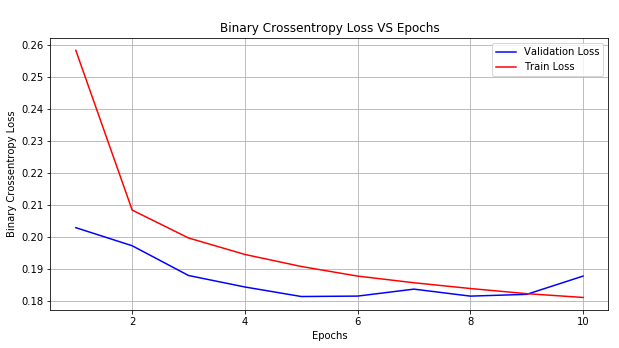

In [50]:
x = list(range(1,11))

# Validation loss
vy = history3.history['val_loss']
# Training loss
ty = history3.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

In [6]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names = ["LSTM layer","Train accuracy","Test accuracy"]
x.add_row(["1x1",0.9286,0.9266])
x.add_row(["2x2",0.9286,0.9266])
x.add_row(["3x3",0.9277,0.9258])

print(x)

+------------+----------------+---------------+
| LSTM layer | Train accuracy | Test accuracy |
+------------+----------------+---------------+
|    1x1     |     0.9286     |     0.9266    |
|    2x2     |     0.9286     |     0.9266    |
|    3x3     |     0.9277     |     0.9258    |
+------------+----------------+---------------+


_________________________________________________________________________________________________________________________